In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from utils.utils import set_seed
set_seed()


from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
#torch.use_deterministic_algorithms(False)
#torch.backends.cudnn.benchmark = False
#torch.autograd.profiler.profile(enabled=False)
#torch.autograd.profiler.emit_nvtx(enabled=False)
#torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [4]:
df = make_stationary(df)

Column: x_1 | Final ADF: -5.4811 | p-value: 0.0000 | Diffs: 1
Column: x_2 | Final ADF: -3.6982 | p-value: 0.0003 | Diffs: 0
Column: x_3 | Final ADF: -3.6538 | p-value: 0.0003 | Diffs: 0
Column: x_4 | Final ADF: -3.3276 | p-value: 0.0010 | Diffs: 0
Column: x_5 | Final ADF: -28.9652 | p-value: 0.0000 | Diffs: 1
Column: x_6 | Final ADF: -27.3830 | p-value: 0.0000 | Diffs: 1
Column: x_7 | Final ADF: -5.1194 | p-value: 0.0000 | Diffs: 1
Column: x_8 | Final ADF: -30.8786 | p-value: 0.0000 | Diffs: 1
Column: x_9 | Final ADF: -3.0565 | p-value: 0.0024 | Diffs: 0
Column: x_10 | Final ADF: -5.8785 | p-value: 0.0000 | Diffs: 1
Column: x_11 | Final ADF: -5.5060 | p-value: 0.0000 | Diffs: 1
Column: x_12 | Final ADF: -27.0496 | p-value: 0.0000 | Diffs: 1
Column: x_13 | Final ADF: -5.5245 | p-value: 0.0000 | Diffs: 1
Column: x_14 | Final ADF: -29.4428 | p-value: 0.0000 | Diffs: 1
Column: x_15 | Final ADF: -23.7157 | p-value: 0.0000 | Diffs: 1
Column: x_16 | Final ADF: -5.1058 | p-value: 0.0000 | Diff

In [5]:
df=df.to_pandas()

In [6]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [7]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [8]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

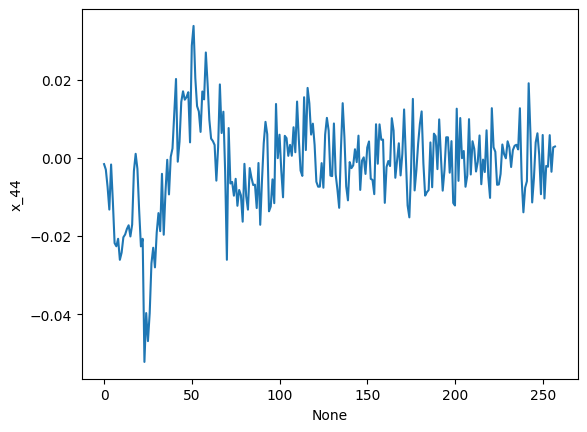

In [9]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [10]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_18','x_19','x_44','x_50']]

In [11]:
normal = df[200:]
bad = df[0:200]

In [12]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50'], dtype='object')

In [13]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [14]:
cols = df.columns.tolist()

In [15]:
cols

['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50']

# Pretraining

In [16]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [35]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None,instantaneous_weight=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad =True)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=200, patience=20,
                  BATCH_SIZE=BATCH_SIZE,rho_max=4,alpha_max=2)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
pd.DataFrame((prior_adj).cpu().detach().numpy(),index=cols,columns=cols)

Epoch 1: Loss = 301.9690
Recon Loss = 320.1398, KL Loss = 0.0000, Lagrangian Loss = 29.4586
Epoch 51: Loss = 15.1541
Recon Loss = 15.0322, KL Loss = 0.7678, Lagrangian Loss = 6.3340
Epoch 101: Loss = 5.9774
Recon Loss = 5.4800, KL Loss = 0.5173, Lagrangian Loss = 2.7307
Epoch 151: Loss = 3.7469
Recon Loss = 3.4642, KL Loss = 0.3201, Lagrangian Loss = 1.9046


,x_1,x_4,x_7,x_13,x_16,x_18,x_19,x_44,x_50
x_1,0.000000,0.463701,0.331602,0.357082,0.332337,0.446658,0.325793,0.330286,0.322070
x_4,0.280336,0.000000,0.356729,0.386473,0.404197,0.305971,0.384953,0.407404,0.302840
x_7,0.322337,0.387143,0.000000,0.415536,0.332255,0.468466,0.347451,0.317093,0.378922
x_13,0.284771,0.357019,0.285732,0.000000,0.314734,0.350673,0.400621,0.369002,0.323369
x_16,0.283832,0.420236,0.353251,0.299617,0.000000,0.318161,0.317730,0.315012,0.312234
x_18,0.371586,0.340347,0.283001,0.410161,0.308738,0.000000,0.311795,0.422890,0.392977
x_19,0.311184,0.412615,0.289547,0.305193,0.327827,0.336896,0.000000,0.288606,0.415722
x_44,0.369653,0.419239,0.358901,0.412631,0.405392,0.334310,0.399950,0.000000,0.318081
x_50,0.298846,0.308027,0.315350,0.326999,0.404068,0.388763,0.302975,0.319219,0.000000


In [45]:
def two_stage_training(model, dataloader, num_epochs_stage1=100, num_epochs_stage2=100, 
                       patience_stage1=10, patience_stage2=10, lr_stage1=1e-3, lr_stage2=5e-4,
                       batch_size=64, rho_max=30.0, alpha_max=15.0):
    """
    Two-stage training process:
    1. Train the reconstruction parts of CausalGraphVAE first
    2. Freeze encoder/decoder and train only the TemporalCausalGraph
    
    Args:
        model: CausalGraphVAE model
        dataloader: Data loader for training
        num_epochs_stage1: Number of epochs for stage 1 training
        num_epochs_stage2: Number of epochs for stage 2 training
        patience_stage1: Early stopping patience for stage 1
        patience_stage2: Early stopping patience for stage 2
        lr_stage1: Learning rate for stage 1
        lr_stage2: Learning rate for stage 2
        batch_size: Batch size
        rho_max: Maximum rho value for acyclicity constraint
        alpha_max: Maximum alpha value for acyclicity constraint
    """
    device = model.device
    print("=== Starting Stage 1: Training Reconstruction Network ===")
    
    # Stage 1: Train for reconstruction
    # Define the optimizer for stage 1
    optimizer_stage1 = optim.Adam(model.parameters(), lr=lr_stage1)
    scheduler_stage1 = ReduceLROnPlateau(optimizer_stage1, 'min', factor=0.5, patience=5, verbose=True)
    
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs_stage1):
        total_recon_loss = 0
        total_kl_loss = 0
        total_samples = 0
        
        for batch_idx, (X_batch, time_batch) in enumerate(dataloader):
            if X_batch.shape[0] < X_batch.shape[2]:
                continue
                
            optimizer_stage1.zero_grad()
            
            # Forward pass
            recon_X, mu, logvar, adj_now, adj_lag = model(X_batch, time_batch)
            
            # Focus only on reconstruction and KL loss
            recon_loss = torch.nn.functional.mse_loss(recon_X, X_batch, reduction='sum')
            beta = min(1.0, epoch / (num_epochs_stage1 * 0.3))  # Gradually increase KL weight
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) * beta
            
            # Total loss (ignoring graph constraints in stage 1)
            loss = recon_loss + kl_loss
            
            loss.backward()
            optimizer_stage1.step()
            
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_samples += X_batch.size(0)
        
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_kl_loss = total_kl_loss / len(dataloader)
        avg_loss = avg_recon_loss + avg_kl_loss
        
        if epoch % 10 == 0:
            print(f"Stage 1 - Epoch {epoch + 1}: Recon Loss = {avg_recon_loss:.4f}, KL Loss = {avg_kl_loss:.4f}")
        
        scheduler_stage1.step(avg_loss)
        
        # Early stopping based on reconstruction loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience_stage1:
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Final Stage 1 - Recon Loss = {avg_recon_loss:.4f}, KL Loss = {avg_kl_loss:.4f}")
                break
    
    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    print("\n=== Starting Stage 2: Training Causal Graph Discovery ===")
    
    # Stage 2: Freeze encoder/decoder, train only the causal graph components
    # Make sure alpha and rho are stored as simple Python values, not tensors requiring gradients
    model.rho = float(model.rho)
    model.alpha = float(model.alpha)
    
    # Freeze parameters of encoder and decoder components
    for name, param in model.named_parameters():
        if any(x in name for x in ['enocder_projection', 'encoder_norm', 'encoder_transformer', 
                                   'mu_layer', 'logvar_layer', 'decoder_projection', 
                                   'decoder_norm', 'decoder_transformer', 'decoder_fc',
                                   'pos_embedding']):
            param.requires_grad = False
    
    # Only optimize parameters of the causal graph component
    causal_graph_params = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            causal_graph_params.append(param)
    
    optimizer_stage2 = optim.Adam(causal_graph_params, lr=lr_stage2)
    scheduler_stage2 = ReduceLROnPlateau(optimizer_stage2, 'min', factor=0.5, patience=5, verbose=True)
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs_stage2):
        total_lagrangian_loss = 0
        total_samples = 0
        
        for batch_idx, (X_batch, time_batch) in enumerate(dataloader):
            if X_batch.shape[0] < X_batch.shape[2]:
                continue
                
            optimizer_stage2.zero_grad()
            
            # Forward pass
            recon_X, mu, logvar, adj_now, adj_lag = model(X_batch, time_batch)
            
            # Focus on graph structure loss
            h_now = model.improved_acyclicity_constraint(adj_now)
            h_lag = model.improved_acyclicity_constraint(adj_lag)
            h_value = h_now * model.instantaneous_weight + h_lag * model.lag_weight
            
            # Ensure h_value is a tensor
            if not isinstance(h_value, torch.Tensor):
                h_value = torch.tensor(h_value, device=device)
            
            # Adaptive weights for DAG constraint
            # Update these values as numbers, not tensors
            current_rho = min(float(rho_max), 1.0 + (epoch / num_epochs_stage2) ** 2)
            current_alpha = min(float(alpha_max), (epoch / num_epochs_stage2) ** 2)
            
            # Store for logging purposes only
            model.rho = current_rho
            model.alpha = current_alpha
            
            # Sparsity penalty
            sparsity_loss = torch.norm(adj_now, p=1) * model.instantaneous_weight + torch.norm(adj_lag, p=1) * model.lag_weight
            
            # Lagrangian loss - use scalar values for alpha and rho
            lagrangian_loss = current_alpha * h_value + 0.5 * current_rho * (h_value ** 2) + 0.01 * sparsity_loss
            
            lagrangian_loss.backward()
            optimizer_stage2.step()
            
            total_lagrangian_loss += lagrangian_loss.item()
            total_samples += X_batch.size(0)
        
        avg_lagrangian_loss = total_lagrangian_loss / len(dataloader)
        
        if epoch % 10 == 0:
            print(f"Stage 2 - Epoch {epoch + 1}: Lagrangian Loss = {avg_lagrangian_loss:.4f}")
            # Safely extract values, handling both tensor and float types
            h_value_scalar = h_value.item() if hasattr(h_value, 'item') else h_value
            rho_scalar = model.rho.item() if hasattr(model.rho, 'item') else model.rho
            alpha_scalar = model.alpha.item() if hasattr(model.alpha, 'item') else model.alpha
            print(f"h_value = {h_value_scalar:.6f}, Rho = {rho_scalar:.2f}, Alpha = {alpha_scalar:.2f}")
        
        scheduler_stage2.step(avg_lagrangian_loss)
        
        # Early stopping
        if avg_lagrangian_loss < best_loss:
            best_loss = avg_lagrangian_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_stage2:
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Final Stage 2 - Lagrangian Loss = {avg_lagrangian_loss:.4f}")
                h_value_scalar = h_value.item() if hasattr(h_value, 'item') else h_value
                print(f"Final h_value = {h_value_scalar:.6f}")
                break
    
    # Unfreeze all parameters for any future use
    for name, param in model.named_parameters():
        param.requires_grad = True
        
    print("Two-stage training completed!")
    return model

In [55]:
dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model and optimizer
fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=prior_adj,instantaneous_weight=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


In [56]:
mod = two_stage_training(fine_tuned, dataloader_bad, num_epochs_stage1=250, num_epochs_stage2=250, 
                       patience_stage1=10, patience_stage2=10, lr_stage1=1e-4, lr_stage2=5e-4,
                       batch_size=64, rho_max=4.0, alpha_max=2.0)

=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 559.5884, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 91.7314, KL Loss = 0.0687
Stage 1 - Epoch 21: Recon Loss = 63.0323, KL Loss = 0.1927
Stage 1 - Epoch 31: Recon Loss = 49.0818, KL Loss = 0.3347
Stage 1 - Epoch 41: Recon Loss = 40.2408, KL Loss = 0.4916
Stage 1 - Epoch 51: Recon Loss = 32.5007, KL Loss = 0.6407
Stage 1 - Epoch 61: Recon Loss = 27.5611, KL Loss = 0.7706
Stage 1 - Epoch 71: Recon Loss = 23.0593, KL Loss = 0.8891
Stage 1 - Epoch 81: Recon Loss = 19.4304, KL Loss = 0.9321
Stage 1 - Epoch 91: Recon Loss = 16.6849, KL Loss = 0.8826
Stage 1 - Epoch 101: Recon Loss = 14.6488, KL Loss = 0.8315
Stage 1 - Epoch 111: Recon Loss = 12.9135, KL Loss = 0.7964
Stage 1 - Epoch 121: Recon Loss = 10.9726, KL Loss = 0.7623
Stage 1 - Epoch 131: Recon Loss = 10.1085, KL Loss = 0.7320
Stage 1 - Epoch 141: Recon Loss = 8.7383, KL Loss = 0.7073
Stage 1 - Epoch 151: Recon Loss = 8.0766, KL Loss = 0

In [59]:
X_data = torch.empty(0,device=device)
T_data = torch.empty(0,device=device)
for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
    X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
    T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))

causes= mod.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])

In [60]:
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_1,0.968134,0.846212,0.993025,1.000000,0.951842,0.250
x_18,0.951594,0.920713,0.926674,0.721191,0.880043,0.000
x_44,1.000000,1.000000,0.955807,0.189421,0.786307,1.000
x_13,0.942407,0.880390,0.935178,0.271856,0.757458,0.500
x_16,0.982514,0.872790,1.000000,0.081940,0.734311,0.500
x_19,0.966350,0.862052,0.981535,0.009714,0.704913,0.875
x_7,0.945484,0.870608,0.945270,0.056109,0.704368,0.250
x_50,0.959366,0.903166,0.948160,0.000000,0.702673,0.750
x_4,0.000000,0.000000,0.000000,NaN,0.000000,0.625


In [61]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj,instantaneous_weight=0.05).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    mod = two_stage_training(fine_tuned, dataloader_bad, num_epochs_stage1=250, num_epochs_stage2=250, 
                       patience_stage1=10, patience_stage2=10, lr_stage1=1e-4, lr_stage2=5e-4,
                       batch_size=64, rho_max=4.0, alpha_max=2.0)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= mod.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_1','x_44']) :
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_1','x_44']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_1','x_44']) :
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_1','x_44']):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_1','x_44']) :
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_1','x_44']) :
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 360.2719, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 88.5896, KL Loss = 0.0972
Stage 1 - Epoch 21: Recon Loss = 57.4996, KL Loss = 0.2360
Stage 1 - Epoch 31: Recon Loss = 43.0930, KL Loss = 0.3957
Stage 1 - Epoch 41: Recon Loss = 34.0815, KL Loss = 0.5784
Stage 1 - Epoch 51: Recon Loss = 27.2830, KL Loss = 0.7414
Stage 1 - Epoch 61: Recon Loss = 23.1813, KL Loss = 0.8941
Stage 1 - Epoch 71: Recon Loss = 19.1889, KL Loss = 0.9985
Stage 1 - Epoch 81: Recon Loss = 15.9863, KL Loss = 1.0009
Stage 1 - Epoch 91: Recon Loss = 13.5651, KL Loss = 0.9038
Stage 1 - Epoch 101: Recon Loss = 11.4121, KL Loss = 0.8354
Stage 1 - Epoch 111: Recon Loss = 10.0564, KL Loss = 0.7726
Stage 1 - Epoch 121: Recon Loss = 8.6766, KL Loss = 0.6982
Stage 1 - Epoch 131: Recon Loss = 7.8787, KL Loss = 0.6704
Stage 1 - Epoch 141: Recon Loss = 7.0884, KL Loss = 0.6045
Stage 1 - Epoch 151: Recon Loss = 6.4861, KL Loss = 0.5

2025-03-25 18:24:44,935 INFO -- Edge Accuracy = 0.00, Instantaneous Accuracy = 0.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 0.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 445.4907, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 86.8348, KL Loss = 0.0790
Stage 1 - Epoch 21: Recon Loss = 54.0634, KL Loss = 0.2096
Stage 1 - Epoch 31: Recon Loss = 43.1174, KL Loss = 0.3645
Stage 1 - Epoch 41: Recon Loss = 33.9958, KL Loss = 0.5336
Stage 1 - Epoch 51: Recon Loss = 28.4221, KL Loss = 0.7268
Stage 1 - Epoch 61: Recon Loss = 23.6444, KL Loss = 0.9093
Stage 1 - Epoch 71: Recon Loss = 20.7065, KL Loss = 1.0670
Stage 1 - Epoch 81: Recon Loss = 17.6079, KL Loss = 1.1281
Stage 1 - Epoch 91: Recon Loss = 15.8473, KL Loss = 1.0901
Stage 1 - Epoch 101: Recon Loss = 13.6993, KL Loss = 1.0622
Stage 1 - Epoch 111: Recon Loss = 12.2719, KL Loss = 0.9954
Stage 1 - Epoch 121: Recon Loss = 10.7028, KL Loss = 0.9274
Stage 1 - Epoch 131: Recon Loss = 9.6279, KL Loss = 0.8503
Stage 1 - Epoch 141: Recon Loss = 8.8764, KL Loss = 0.8178
Stage 1 - Epoch 151: Recon Loss = 7.9729, KL Loss = 0.

2025-03-25 18:32:20,787 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 50.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 0.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 418.6414, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 75.9323, KL Loss = 0.0889
Stage 1 - Epoch 21: Recon Loss = 52.6692, KL Loss = 0.2314
Stage 1 - Epoch 31: Recon Loss = 41.1838, KL Loss = 0.3817
Stage 1 - Epoch 41: Recon Loss = 34.3638, KL Loss = 0.5436
Stage 1 - Epoch 51: Recon Loss = 27.9822, KL Loss = 0.7014
Stage 1 - Epoch 61: Recon Loss = 23.4552, KL Loss = 0.8379
Stage 1 - Epoch 71: Recon Loss = 19.6104, KL Loss = 0.9669
Stage 1 - Epoch 81: Recon Loss = 16.5442, KL Loss = 0.9897
Stage 1 - Epoch 91: Recon Loss = 14.3943, KL Loss = 0.9212
Stage 1 - Epoch 101: Recon Loss = 12.1433, KL Loss = 0.8603
Stage 1 - Epoch 111: Recon Loss = 10.6921, KL Loss = 0.8208
Stage 1 - Epoch 121: Recon Loss = 9.3665, KL Loss = 0.7626
Stage 1 - Epoch 131: Recon Loss = 8.3500, KL Loss = 0.7179
Stage 1 - Epoch 141: Recon Loss = 7.3203, KL Loss = 0.6911
Stage 1 - Epoch 151: Recon Loss = 6.7444, KL Loss = 0.6

2025-03-25 18:39:18,487 INFO -- Edge Accuracy = 66.67, Instantaneous Accuracy = 33.33, Lagged Accuracy = 66.67, Counterfactual Accuracy = 0.00,  Blended Accuracy = 0.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 329.9357, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 73.1241, KL Loss = 0.0785
Stage 1 - Epoch 21: Recon Loss = 48.5599, KL Loss = 0.2099
Stage 1 - Epoch 31: Recon Loss = 37.2587, KL Loss = 0.3683
Stage 1 - Epoch 41: Recon Loss = 30.6069, KL Loss = 0.5202
Stage 1 - Epoch 51: Recon Loss = 25.2421, KL Loss = 0.6905
Stage 1 - Epoch 61: Recon Loss = 21.2271, KL Loss = 0.8424
Stage 1 - Epoch 71: Recon Loss = 18.4473, KL Loss = 0.9531
Stage 1 - Epoch 81: Recon Loss = 15.6853, KL Loss = 0.9959
Stage 1 - Epoch 91: Recon Loss = 13.7008, KL Loss = 0.9730
Stage 1 - Epoch 101: Recon Loss = 11.6455, KL Loss = 0.9002
Stage 1 - Epoch 111: Recon Loss = 10.2372, KL Loss = 0.8491
Stage 1 - Epoch 121: Recon Loss = 8.8571, KL Loss = 0.8125
Stage 1 - Epoch 131: Recon Loss = 7.9064, KL Loss = 0.7372
Stage 1 - Epoch 141: Recon Loss = 7.3727, KL Loss = 0.6903
Stage 1 - Epoch 151: Recon Loss = 6.6499, KL Loss = 0.6

2025-03-25 18:45:51,957 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 25.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 25.00,  Blended Accuracy = 25.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 479.5578, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 88.4638, KL Loss = 0.0784
Stage 1 - Epoch 21: Recon Loss = 56.0121, KL Loss = 0.2037
Stage 1 - Epoch 31: Recon Loss = 42.8122, KL Loss = 0.3563
Stage 1 - Epoch 41: Recon Loss = 33.8958, KL Loss = 0.5126
Stage 1 - Epoch 51: Recon Loss = 28.4487, KL Loss = 0.6694
Stage 1 - Epoch 61: Recon Loss = 24.3181, KL Loss = 0.8325
Stage 1 - Epoch 71: Recon Loss = 21.8442, KL Loss = 0.9623
Stage 1 - Epoch 81: Recon Loss = 18.5060, KL Loss = 1.0016
Stage 1 - Epoch 91: Recon Loss = 16.5845, KL Loss = 0.9689
Stage 1 - Epoch 101: Recon Loss = 14.6055, KL Loss = 0.9414
Stage 1 - Epoch 111: Recon Loss = 13.1133, KL Loss = 0.8802
Stage 1 - Epoch 121: Recon Loss = 11.9605, KL Loss = 0.8515
Stage 1 - Epoch 131: Recon Loss = 10.5525, KL Loss = 0.8014
Stage 1 - Epoch 141: Recon Loss = 9.7964, KL Loss = 0.7658
Stage 1 - Epoch 151: Recon Loss = 9.0374, KL Loss = 0

2025-03-25 18:52:35,044 INFO -- Edge Accuracy = 60.00, Instantaneous Accuracy = 20.00, Lagged Accuracy = 60.00, Counterfactual Accuracy = 20.00,  Blended Accuracy = 20.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 454.0530, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 84.8633, KL Loss = 0.1435
Stage 1 - Epoch 21: Recon Loss = 55.1841, KL Loss = 0.3252
Stage 1 - Epoch 31: Recon Loss = 42.1972, KL Loss = 0.5154
Stage 1 - Epoch 41: Recon Loss = 33.9135, KL Loss = 0.6852
Stage 1 - Epoch 51: Recon Loss = 27.0199, KL Loss = 0.8544
Stage 1 - Epoch 61: Recon Loss = 22.7342, KL Loss = 0.9974
Stage 1 - Epoch 71: Recon Loss = 19.5948, KL Loss = 1.1006
Stage 1 - Epoch 81: Recon Loss = 16.8573, KL Loss = 1.0964
Stage 1 - Epoch 91: Recon Loss = 14.3855, KL Loss = 1.0195
Stage 1 - Epoch 101: Recon Loss = 12.6534, KL Loss = 0.9517
Stage 1 - Epoch 111: Recon Loss = 10.8839, KL Loss = 0.9156
Stage 1 - Epoch 121: Recon Loss = 9.7287, KL Loss = 0.8615
Stage 1 - Epoch 131: Recon Loss = 8.9849, KL Loss = 0.8263
Stage 1 - Epoch 141: Recon Loss = 7.9064, KL Loss = 0.7757
Stage 1 - Epoch 151: Recon Loss = 7.2223, KL Loss = 0.7

2025-03-25 19:00:44,115 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 16.67, Lagged Accuracy = 50.00, Counterfactual Accuracy = 16.67,  Blended Accuracy = 16.67,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 417.2436, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 98.4922, KL Loss = 0.0964
Stage 1 - Epoch 21: Recon Loss = 64.1883, KL Loss = 0.2477
Stage 1 - Epoch 31: Recon Loss = 47.6524, KL Loss = 0.4295
Stage 1 - Epoch 41: Recon Loss = 38.9305, KL Loss = 0.6054
Stage 1 - Epoch 51: Recon Loss = 32.1280, KL Loss = 0.7784
Stage 1 - Epoch 61: Recon Loss = 27.1870, KL Loss = 0.9359
Stage 1 - Epoch 71: Recon Loss = 23.5774, KL Loss = 1.0494
Stage 1 - Epoch 81: Recon Loss = 19.6746, KL Loss = 1.0764
Stage 1 - Epoch 91: Recon Loss = 17.0526, KL Loss = 1.0081
Stage 1 - Epoch 101: Recon Loss = 14.8462, KL Loss = 0.9342
Stage 1 - Epoch 111: Recon Loss = 12.6771, KL Loss = 0.8916
Stage 1 - Epoch 121: Recon Loss = 11.1522, KL Loss = 0.8382
Stage 1 - Epoch 131: Recon Loss = 9.8706, KL Loss = 0.7966
Stage 1 - Epoch 141: Recon Loss = 8.5577, KL Loss = 0.7394
Stage 1 - Epoch 151: Recon Loss = 7.8317, KL Loss = 0.

2025-03-25 19:08:05,644 INFO -- Edge Accuracy = 42.86, Instantaneous Accuracy = 14.29, Lagged Accuracy = 42.86, Counterfactual Accuracy = 14.29,  Blended Accuracy = 14.29,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 354.9846, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 77.4396, KL Loss = 0.0766
Stage 1 - Epoch 21: Recon Loss = 55.6482, KL Loss = 0.1942
Stage 1 - Epoch 31: Recon Loss = 42.9880, KL Loss = 0.3272
Stage 1 - Epoch 41: Recon Loss = 34.7011, KL Loss = 0.4686
Stage 1 - Epoch 51: Recon Loss = 28.6754, KL Loss = 0.6105
Stage 1 - Epoch 61: Recon Loss = 24.6345, KL Loss = 0.7322
Stage 1 - Epoch 71: Recon Loss = 21.2621, KL Loss = 0.8519
Stage 1 - Epoch 81: Recon Loss = 18.0621, KL Loss = 0.8755
Stage 1 - Epoch 91: Recon Loss = 15.4283, KL Loss = 0.8561
Stage 1 - Epoch 101: Recon Loss = 13.2682, KL Loss = 0.8126
Stage 1 - Epoch 111: Recon Loss = 11.8936, KL Loss = 0.7707
Stage 1 - Epoch 121: Recon Loss = 10.1547, KL Loss = 0.7411
Stage 1 - Epoch 131: Recon Loss = 8.8210, KL Loss = 0.6914
Stage 1 - Epoch 141: Recon Loss = 7.9436, KL Loss = 0.6572
Stage 1 - Epoch 151: Recon Loss = 7.0032, KL Loss = 0.

2025-03-25 19:15:27,886 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 25.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 12.50,  Blended Accuracy = 12.50,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 306.5313, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 71.4965, KL Loss = 0.1191
Stage 1 - Epoch 21: Recon Loss = 49.8482, KL Loss = 0.3320
Stage 1 - Epoch 31: Recon Loss = 37.3830, KL Loss = 0.5847
Stage 1 - Epoch 41: Recon Loss = 28.5664, KL Loss = 0.8428
Stage 1 - Epoch 51: Recon Loss = 25.9857, KL Loss = 1.0746
Stage 1 - Epoch 61: Recon Loss = 21.4128, KL Loss = 1.2545
Stage 1 - Epoch 71: Recon Loss = 18.3149, KL Loss = 1.3771
Stage 1 - Epoch 81: Recon Loss = 16.0584, KL Loss = 1.3631
Stage 1 - Epoch 91: Recon Loss = 14.1812, KL Loss = 1.2490
Stage 1 - Epoch 101: Recon Loss = 12.6801, KL Loss = 1.1635
Stage 1 - Epoch 111: Recon Loss = 11.1113, KL Loss = 1.0869
Stage 1 - Epoch 121: Recon Loss = 10.1432, KL Loss = 1.0192
Stage 1 - Epoch 131: Recon Loss = 8.7555, KL Loss = 0.9746
Stage 1 - Epoch 141: Recon Loss = 8.0574, KL Loss = 0.9161
Stage 1 - Epoch 151: Recon Loss = 7.2656, KL Loss = 0.

2025-03-25 19:23:23,371 INFO -- Edge Accuracy = 44.44, Instantaneous Accuracy = 33.33, Lagged Accuracy = 44.44, Counterfactual Accuracy = 11.11,  Blended Accuracy = 11.11,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 314.2557, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 78.4705, KL Loss = 0.1260
Stage 1 - Epoch 21: Recon Loss = 52.4903, KL Loss = 0.3114
Stage 1 - Epoch 31: Recon Loss = 40.4963, KL Loss = 0.5172
Stage 1 - Epoch 41: Recon Loss = 34.0440, KL Loss = 0.7372
Stage 1 - Epoch 51: Recon Loss = 28.0889, KL Loss = 0.9363
Stage 1 - Epoch 61: Recon Loss = 23.9218, KL Loss = 1.0969
Stage 1 - Epoch 71: Recon Loss = 21.0408, KL Loss = 1.2214
Stage 1 - Epoch 81: Recon Loss = 18.5022, KL Loss = 1.2087
Stage 1 - Epoch 91: Recon Loss = 15.6513, KL Loss = 1.1028
Stage 1 - Epoch 101: Recon Loss = 13.7511, KL Loss = 1.0474
Stage 1 - Epoch 111: Recon Loss = 11.9622, KL Loss = 0.9727
Stage 1 - Epoch 121: Recon Loss = 10.6702, KL Loss = 0.9213
Stage 1 - Epoch 131: Recon Loss = 9.3408, KL Loss = 0.8726
Stage 1 - Epoch 141: Recon Loss = 8.7654, KL Loss = 0.8246
Stage 1 - Epoch 151: Recon Loss = 7.9190, KL Loss = 0.

2025-03-25 19:30:34,752 INFO -- Edge Accuracy = 40.00, Instantaneous Accuracy = 30.00, Lagged Accuracy = 40.00, Counterfactual Accuracy = 20.00,  Blended Accuracy = 20.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 677.9729, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 105.2057, KL Loss = 0.1138
Stage 1 - Epoch 21: Recon Loss = 65.8451, KL Loss = 0.3056
Stage 1 - Epoch 31: Recon Loss = 49.2336, KL Loss = 0.5196
Stage 1 - Epoch 41: Recon Loss = 38.6152, KL Loss = 0.7225
Stage 1 - Epoch 51: Recon Loss = 31.4157, KL Loss = 0.9537
Stage 1 - Epoch 61: Recon Loss = 26.8815, KL Loss = 1.1273
Stage 1 - Epoch 71: Recon Loss = 22.8721, KL Loss = 1.2796
Stage 1 - Epoch 81: Recon Loss = 19.5876, KL Loss = 1.2920
Stage 1 - Epoch 91: Recon Loss = 17.5760, KL Loss = 1.2020
Stage 1 - Epoch 101: Recon Loss = 14.8286, KL Loss = 1.1029
Stage 1 - Epoch 111: Recon Loss = 13.1416, KL Loss = 1.0059
Stage 1 - Epoch 121: Recon Loss = 11.5928, KL Loss = 0.9404
Stage 1 - Epoch 131: Recon Loss = 10.3671, KL Loss = 0.8616
Stage 1 - Epoch 141: Recon Loss = 9.4441, KL Loss = 0.8082
Stage 1 - Epoch 151: Recon Loss = 8.4369, KL Loss = 

2025-03-25 19:38:24,805 INFO -- Edge Accuracy = 45.45, Instantaneous Accuracy = 27.27, Lagged Accuracy = 45.45, Counterfactual Accuracy = 18.18,  Blended Accuracy = 18.18,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 366.8478, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 75.3432, KL Loss = 0.0916
Stage 1 - Epoch 21: Recon Loss = 48.4685, KL Loss = 0.2540
Stage 1 - Epoch 31: Recon Loss = 36.2173, KL Loss = 0.4408
Stage 1 - Epoch 41: Recon Loss = 29.9370, KL Loss = 0.6314
Stage 1 - Epoch 51: Recon Loss = 25.1597, KL Loss = 0.8097
Stage 1 - Epoch 61: Recon Loss = 20.9262, KL Loss = 0.9790
Stage 1 - Epoch 71: Recon Loss = 18.2317, KL Loss = 1.1016
Stage 1 - Epoch 81: Recon Loss = 15.9988, KL Loss = 1.1249
Stage 1 - Epoch 91: Recon Loss = 13.7954, KL Loss = 1.0421
Stage 1 - Epoch 101: Recon Loss = 11.7918, KL Loss = 0.9843
Stage 1 - Epoch 111: Recon Loss = 10.4004, KL Loss = 0.9214
Stage 1 - Epoch 121: Recon Loss = 9.4600, KL Loss = 0.8792
Stage 1 - Epoch 131: Recon Loss = 8.2212, KL Loss = 0.8207
Stage 1 - Epoch 141: Recon Loss = 7.3966, KL Loss = 0.7909
Stage 1 - Epoch 151: Recon Loss = 6.8521, KL Loss = 0.7

2025-03-25 19:45:55,751 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 25.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 16.67,  Blended Accuracy = 16.67,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 538.5498, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 94.4005, KL Loss = 0.1457
Stage 1 - Epoch 21: Recon Loss = 61.5018, KL Loss = 0.3527
Stage 1 - Epoch 31: Recon Loss = 48.7352, KL Loss = 0.5870
Stage 1 - Epoch 41: Recon Loss = 40.5967, KL Loss = 0.8162
Stage 1 - Epoch 51: Recon Loss = 33.1479, KL Loss = 1.0439
Stage 1 - Epoch 61: Recon Loss = 28.4166, KL Loss = 1.2596
Stage 1 - Epoch 71: Recon Loss = 25.0319, KL Loss = 1.4187
Stage 1 - Epoch 81: Recon Loss = 21.0515, KL Loss = 1.4504
Stage 1 - Epoch 91: Recon Loss = 18.9076, KL Loss = 1.3416
Stage 1 - Epoch 101: Recon Loss = 16.2406, KL Loss = 1.2001
Stage 1 - Epoch 111: Recon Loss = 13.7948, KL Loss = 1.0859
Stage 1 - Epoch 121: Recon Loss = 12.4526, KL Loss = 0.9993
Stage 1 - Epoch 131: Recon Loss = 11.4643, KL Loss = 0.9188
Stage 1 - Epoch 141: Recon Loss = 10.1286, KL Loss = 0.8610
Stage 1 - Epoch 151: Recon Loss = 9.2519, KL Loss = 

2025-03-25 19:53:18,025 INFO -- Edge Accuracy = 46.15, Instantaneous Accuracy = 23.08, Lagged Accuracy = 46.15, Counterfactual Accuracy = 23.08,  Blended Accuracy = 23.08,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 421.7207, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 81.5206, KL Loss = 0.0610
Stage 1 - Epoch 21: Recon Loss = 56.5250, KL Loss = 0.1844
Stage 1 - Epoch 31: Recon Loss = 42.4007, KL Loss = 0.3368
Stage 1 - Epoch 41: Recon Loss = 34.7343, KL Loss = 0.5114
Stage 1 - Epoch 51: Recon Loss = 28.6248, KL Loss = 0.6706
Stage 1 - Epoch 61: Recon Loss = 23.1592, KL Loss = 0.8123
Stage 1 - Epoch 71: Recon Loss = 18.8942, KL Loss = 0.9383
Stage 1 - Epoch 81: Recon Loss = 16.7724, KL Loss = 0.9682
Stage 1 - Epoch 91: Recon Loss = 13.2609, KL Loss = 0.9312
Stage 1 - Epoch 101: Recon Loss = 11.5181, KL Loss = 0.8733
Stage 1 - Epoch 111: Recon Loss = 9.7810, KL Loss = 0.8016
Stage 1 - Epoch 121: Recon Loss = 8.6774, KL Loss = 0.7695
Stage 1 - Epoch 131: Recon Loss = 7.8174, KL Loss = 0.7165
Stage 1 - Epoch 141: Recon Loss = 6.6973, KL Loss = 0.6874
Stage 1 - Epoch 151: Recon Loss = 6.1852, KL Loss = 0.60

2025-03-25 20:00:45,292 INFO -- Edge Accuracy = 42.86, Instantaneous Accuracy = 28.57, Lagged Accuracy = 42.86, Counterfactual Accuracy = 21.43,  Blended Accuracy = 21.43,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 286.3210, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 73.4487, KL Loss = 0.1071
Stage 1 - Epoch 21: Recon Loss = 48.5038, KL Loss = 0.2681
Stage 1 - Epoch 31: Recon Loss = 37.1570, KL Loss = 0.4490
Stage 1 - Epoch 41: Recon Loss = 29.4334, KL Loss = 0.6233
Stage 1 - Epoch 51: Recon Loss = 23.7826, KL Loss = 0.7986
Stage 1 - Epoch 61: Recon Loss = 19.7055, KL Loss = 0.9381
Stage 1 - Epoch 71: Recon Loss = 16.9479, KL Loss = 1.0461
Stage 1 - Epoch 81: Recon Loss = 13.5583, KL Loss = 1.0291
Stage 1 - Epoch 91: Recon Loss = 11.2027, KL Loss = 0.9318
Stage 1 - Epoch 101: Recon Loss = 9.7004, KL Loss = 0.8308
Stage 1 - Epoch 111: Recon Loss = 8.6280, KL Loss = 0.7534
Stage 1 - Epoch 121: Recon Loss = 7.3197, KL Loss = 0.6969
Stage 1 - Epoch 131: Recon Loss = 6.6224, KL Loss = 0.6578
Stage 1 - Epoch 141: Recon Loss = 6.1202, KL Loss = 0.5984
Stage 1 - Epoch 151: Recon Loss = 5.5914, KL Loss = 0.551

2025-03-25 20:07:40,022 INFO -- Edge Accuracy = 40.00, Instantaneous Accuracy = 26.67, Lagged Accuracy = 40.00, Counterfactual Accuracy = 20.00,  Blended Accuracy = 20.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 367.5409, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 84.9381, KL Loss = 0.0866
Stage 1 - Epoch 21: Recon Loss = 56.9613, KL Loss = 0.2138
Stage 1 - Epoch 31: Recon Loss = 45.1865, KL Loss = 0.3700
Stage 1 - Epoch 41: Recon Loss = 36.1473, KL Loss = 0.5383
Stage 1 - Epoch 51: Recon Loss = 29.7249, KL Loss = 0.7128
Stage 1 - Epoch 61: Recon Loss = 25.8573, KL Loss = 0.8490
Stage 1 - Epoch 71: Recon Loss = 22.6099, KL Loss = 0.9734
Stage 1 - Epoch 81: Recon Loss = 20.2324, KL Loss = 0.9920
Stage 1 - Epoch 91: Recon Loss = 17.1737, KL Loss = 0.9582
Stage 1 - Epoch 101: Recon Loss = 15.0070, KL Loss = 0.9019
Stage 1 - Epoch 111: Recon Loss = 13.4716, KL Loss = 0.8530
Stage 1 - Epoch 121: Recon Loss = 11.7085, KL Loss = 0.8143
Stage 1 - Epoch 131: Recon Loss = 10.4818, KL Loss = 0.7735
Stage 1 - Epoch 141: Recon Loss = 9.4927, KL Loss = 0.7243
Stage 1 - Epoch 151: Recon Loss = 8.5515, KL Loss = 0

2025-03-25 20:15:53,006 INFO -- Edge Accuracy = 37.50, Instantaneous Accuracy = 25.00, Lagged Accuracy = 37.50, Counterfactual Accuracy = 18.75,  Blended Accuracy = 18.75,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 430.5973, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 85.2934, KL Loss = 0.0942
Stage 1 - Epoch 21: Recon Loss = 54.3731, KL Loss = 0.2529
Stage 1 - Epoch 31: Recon Loss = 41.6554, KL Loss = 0.4280
Stage 1 - Epoch 41: Recon Loss = 34.7232, KL Loss = 0.6068
Stage 1 - Epoch 51: Recon Loss = 28.9708, KL Loss = 0.7983
Stage 1 - Epoch 61: Recon Loss = 25.4183, KL Loss = 0.9541
Stage 1 - Epoch 71: Recon Loss = 21.5969, KL Loss = 1.0860
Stage 1 - Epoch 81: Recon Loss = 18.2966, KL Loss = 1.1139
Stage 1 - Epoch 91: Recon Loss = 15.9520, KL Loss = 1.0468
Stage 1 - Epoch 101: Recon Loss = 14.0723, KL Loss = 1.0041
Stage 1 - Epoch 111: Recon Loss = 12.4615, KL Loss = 0.9138
Stage 1 - Epoch 121: Recon Loss = 10.7758, KL Loss = 0.8578
Stage 1 - Epoch 131: Recon Loss = 9.4523, KL Loss = 0.8130
Stage 1 - Epoch 141: Recon Loss = 8.6354, KL Loss = 0.7701
Stage 1 - Epoch 151: Recon Loss = 7.4904, KL Loss = 0.

2025-03-25 20:23:40,440 INFO -- Edge Accuracy = 35.29, Instantaneous Accuracy = 29.41, Lagged Accuracy = 35.29, Counterfactual Accuracy = 17.65,  Blended Accuracy = 17.65,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 343.5347, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 83.6632, KL Loss = 0.1073
Stage 1 - Epoch 21: Recon Loss = 55.2426, KL Loss = 0.2586
Stage 1 - Epoch 31: Recon Loss = 41.4658, KL Loss = 0.4241
Stage 1 - Epoch 41: Recon Loss = 33.2306, KL Loss = 0.5930
Stage 1 - Epoch 51: Recon Loss = 26.8713, KL Loss = 0.7621
Stage 1 - Epoch 61: Recon Loss = 22.3276, KL Loss = 0.9108
Stage 1 - Epoch 71: Recon Loss = 18.7474, KL Loss = 1.0166
Stage 1 - Epoch 81: Recon Loss = 16.0799, KL Loss = 1.0185
Stage 1 - Epoch 91: Recon Loss = 13.2510, KL Loss = 0.9299
Stage 1 - Epoch 101: Recon Loss = 11.3435, KL Loss = 0.8730
Stage 1 - Epoch 111: Recon Loss = 9.8341, KL Loss = 0.7874
Stage 1 - Epoch 121: Recon Loss = 8.3694, KL Loss = 0.7155
Stage 1 - Epoch 131: Recon Loss = 7.6635, KL Loss = 0.6490
Stage 1 - Epoch 141: Recon Loss = 6.7626, KL Loss = 0.6058
Stage 1 - Epoch 151: Recon Loss = 6.0264, KL Loss = 0.55

2025-03-25 20:30:42,625 INFO -- Edge Accuracy = 33.33, Instantaneous Accuracy = 27.78, Lagged Accuracy = 33.33, Counterfactual Accuracy = 16.67,  Blended Accuracy = 16.67,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 299.7363, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 76.4435, KL Loss = 0.0960
Stage 1 - Epoch 21: Recon Loss = 51.6670, KL Loss = 0.2648
Stage 1 - Epoch 31: Recon Loss = 38.6773, KL Loss = 0.4558
Stage 1 - Epoch 41: Recon Loss = 31.1783, KL Loss = 0.6328
Stage 1 - Epoch 51: Recon Loss = 25.4726, KL Loss = 0.7901
Stage 1 - Epoch 61: Recon Loss = 22.1236, KL Loss = 0.9137
Stage 1 - Epoch 71: Recon Loss = 18.9822, KL Loss = 0.9790
Stage 1 - Epoch 81: Recon Loss = 15.7533, KL Loss = 0.9590
Stage 1 - Epoch 91: Recon Loss = 14.2379, KL Loss = 0.8621
Stage 1 - Epoch 101: Recon Loss = 12.2637, KL Loss = 0.7972
Stage 1 - Epoch 111: Recon Loss = 10.7056, KL Loss = 0.7433
Stage 1 - Epoch 121: Recon Loss = 8.9922, KL Loss = 0.6952
Stage 1 - Epoch 131: Recon Loss = 8.0614, KL Loss = 0.6525
Stage 1 - Epoch 141: Recon Loss = 7.2066, KL Loss = 0.5978
Stage 1 - Epoch 151: Recon Loss = 6.5691, KL Loss = 0.5

2025-03-25 20:37:25,479 INFO -- Edge Accuracy = 31.58, Instantaneous Accuracy = 26.32, Lagged Accuracy = 31.58, Counterfactual Accuracy = 15.79,  Blended Accuracy = 15.79,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 482.2498, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 87.6261, KL Loss = 0.0719
Stage 1 - Epoch 21: Recon Loss = 54.9400, KL Loss = 0.2057
Stage 1 - Epoch 31: Recon Loss = 43.1431, KL Loss = 0.3651
Stage 1 - Epoch 41: Recon Loss = 34.4451, KL Loss = 0.5255
Stage 1 - Epoch 51: Recon Loss = 29.0674, KL Loss = 0.6911
Stage 1 - Epoch 61: Recon Loss = 24.2838, KL Loss = 0.8505
Stage 1 - Epoch 71: Recon Loss = 20.9373, KL Loss = 1.0115
Stage 1 - Epoch 81: Recon Loss = 18.0916, KL Loss = 1.0518
Stage 1 - Epoch 91: Recon Loss = 15.9983, KL Loss = 1.0271
Stage 1 - Epoch 101: Recon Loss = 13.6834, KL Loss = 0.9820
Stage 1 - Epoch 111: Recon Loss = 12.1115, KL Loss = 0.9428
Stage 1 - Epoch 121: Recon Loss = 10.7626, KL Loss = 0.8901
Stage 1 - Epoch 131: Recon Loss = 9.6308, KL Loss = 0.8244
Stage 1 - Epoch 141: Recon Loss = 8.8297, KL Loss = 0.7727
Stage 1 - Epoch 151: Recon Loss = 7.8727, KL Loss = 0.

2025-03-25 20:44:52,958 INFO -- Edge Accuracy = 30.00, Instantaneous Accuracy = 25.00, Lagged Accuracy = 30.00, Counterfactual Accuracy = 15.00,  Blended Accuracy = 15.00,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 419.8927, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 80.8449, KL Loss = 0.0578
Stage 1 - Epoch 21: Recon Loss = 53.6111, KL Loss = 0.1798
Stage 1 - Epoch 31: Recon Loss = 40.0979, KL Loss = 0.3258
Stage 1 - Epoch 41: Recon Loss = 31.5250, KL Loss = 0.4829
Stage 1 - Epoch 51: Recon Loss = 25.6975, KL Loss = 0.6493
Stage 1 - Epoch 61: Recon Loss = 22.2069, KL Loss = 0.7754
Stage 1 - Epoch 71: Recon Loss = 18.2168, KL Loss = 0.9068
Stage 1 - Epoch 81: Recon Loss = 15.7239, KL Loss = 0.9262
Stage 1 - Epoch 91: Recon Loss = 13.6099, KL Loss = 0.8738
Stage 1 - Epoch 101: Recon Loss = 11.6896, KL Loss = 0.8509
Stage 1 - Epoch 111: Recon Loss = 10.3501, KL Loss = 0.8005
Stage 1 - Epoch 121: Recon Loss = 9.1924, KL Loss = 0.7535
Stage 1 - Epoch 131: Recon Loss = 8.2578, KL Loss = 0.7242
Stage 1 - Epoch 141: Recon Loss = 7.6614, KL Loss = 0.6781
Stage 1 - Epoch 151: Recon Loss = 6.9786, KL Loss = 0.6

2025-03-25 20:52:14,877 INFO -- Edge Accuracy = 33.33, Instantaneous Accuracy = 23.81, Lagged Accuracy = 33.33, Counterfactual Accuracy = 14.29,  Blended Accuracy = 14.29,  RR Accuracy = 0.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 420.0742, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 89.9151, KL Loss = 0.0609
Stage 1 - Epoch 21: Recon Loss = 54.9613, KL Loss = 0.1823
Stage 1 - Epoch 31: Recon Loss = 43.2471, KL Loss = 0.3200
Stage 1 - Epoch 41: Recon Loss = 33.6641, KL Loss = 0.4732
Stage 1 - Epoch 51: Recon Loss = 28.6951, KL Loss = 0.6217
Stage 1 - Epoch 61: Recon Loss = 23.6511, KL Loss = 0.7480
Stage 1 - Epoch 71: Recon Loss = 20.0394, KL Loss = 0.8712
Stage 1 - Epoch 81: Recon Loss = 17.4055, KL Loss = 0.8774
Stage 1 - Epoch 91: Recon Loss = 15.0709, KL Loss = 0.8385
Stage 1 - Epoch 101: Recon Loss = 12.8754, KL Loss = 0.7763
Stage 1 - Epoch 111: Recon Loss = 11.7413, KL Loss = 0.7377
Stage 1 - Epoch 121: Recon Loss = 10.5302, KL Loss = 0.7047
Stage 1 - Epoch 131: Recon Loss = 9.3433, KL Loss = 0.6507
Stage 1 - Epoch 141: Recon Loss = 8.5007, KL Loss = 0.6208
Stage 1 - Epoch 151: Recon Loss = 7.7327, KL Loss = 0.

2025-03-25 20:59:23,828 INFO -- Edge Accuracy = 31.82, Instantaneous Accuracy = 22.73, Lagged Accuracy = 31.82, Counterfactual Accuracy = 18.18,  Blended Accuracy = 18.18,  RR Accuracy = 4.55  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 439.8472, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 89.6095, KL Loss = 0.0914
Stage 1 - Epoch 21: Recon Loss = 57.3274, KL Loss = 0.2279
Stage 1 - Epoch 31: Recon Loss = 42.5854, KL Loss = 0.3816
Stage 1 - Epoch 41: Recon Loss = 34.0264, KL Loss = 0.5342
Stage 1 - Epoch 51: Recon Loss = 28.4955, KL Loss = 0.6876
Stage 1 - Epoch 61: Recon Loss = 23.3938, KL Loss = 0.8537
Stage 1 - Epoch 71: Recon Loss = 19.6170, KL Loss = 0.9709
Stage 1 - Epoch 81: Recon Loss = 17.0452, KL Loss = 0.9894
Stage 1 - Epoch 91: Recon Loss = 13.9829, KL Loss = 0.9479
Stage 1 - Epoch 101: Recon Loss = 12.5268, KL Loss = 0.9054
Stage 1 - Epoch 111: Recon Loss = 10.5698, KL Loss = 0.8408
Stage 1 - Epoch 121: Recon Loss = 9.6110, KL Loss = 0.7785
Stage 1 - Epoch 131: Recon Loss = 8.2167, KL Loss = 0.7249
Stage 1 - Epoch 141: Recon Loss = 7.4307, KL Loss = 0.6612
Stage 1 - Epoch 151: Recon Loss = 6.6257, KL Loss = 0.6

2025-03-25 21:06:23,002 INFO -- Edge Accuracy = 30.43, Instantaneous Accuracy = 21.74, Lagged Accuracy = 30.43, Counterfactual Accuracy = 17.39,  Blended Accuracy = 17.39,  RR Accuracy = 4.35  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 833.3541, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 99.1625, KL Loss = 0.0840
Stage 1 - Epoch 21: Recon Loss = 64.5565, KL Loss = 0.2206
Stage 1 - Epoch 31: Recon Loss = 45.9328, KL Loss = 0.3747
Stage 1 - Epoch 41: Recon Loss = 38.1206, KL Loss = 0.5370
Stage 1 - Epoch 51: Recon Loss = 33.7370, KL Loss = 0.7066
Stage 1 - Epoch 61: Recon Loss = 28.3181, KL Loss = 0.8724
Stage 1 - Epoch 71: Recon Loss = 24.7004, KL Loss = 1.0257
Stage 1 - Epoch 81: Recon Loss = 21.1082, KL Loss = 1.0843
Stage 1 - Epoch 91: Recon Loss = 18.5111, KL Loss = 1.0668
Stage 1 - Epoch 101: Recon Loss = 16.1767, KL Loss = 1.0374
Stage 1 - Epoch 111: Recon Loss = 14.0658, KL Loss = 0.9809
Stage 1 - Epoch 121: Recon Loss = 12.4584, KL Loss = 0.9505
Stage 1 - Epoch 131: Recon Loss = 11.6154, KL Loss = 0.8915
Stage 1 - Epoch 141: Recon Loss = 10.2786, KL Loss = 0.8507
Stage 1 - Epoch 151: Recon Loss = 9.2643, KL Loss = 

2025-03-25 21:13:46,541 INFO -- Edge Accuracy = 29.17, Instantaneous Accuracy = 20.83, Lagged Accuracy = 29.17, Counterfactual Accuracy = 16.67,  Blended Accuracy = 16.67,  RR Accuracy = 4.17  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 322.9245, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 76.4519, KL Loss = 0.1032
Stage 1 - Epoch 21: Recon Loss = 50.9188, KL Loss = 0.2525
Stage 1 - Epoch 31: Recon Loss = 38.9388, KL Loss = 0.4234
Stage 1 - Epoch 41: Recon Loss = 32.7062, KL Loss = 0.5820
Stage 1 - Epoch 51: Recon Loss = 28.2194, KL Loss = 0.7556
Stage 1 - Epoch 61: Recon Loss = 22.4042, KL Loss = 0.8830
Stage 1 - Epoch 71: Recon Loss = 19.1886, KL Loss = 0.9857
Stage 1 - Epoch 81: Recon Loss = 16.1250, KL Loss = 0.9800
Stage 1 - Epoch 91: Recon Loss = 13.6501, KL Loss = 0.9142
Stage 1 - Epoch 101: Recon Loss = 11.5124, KL Loss = 0.8510
Stage 1 - Epoch 111: Recon Loss = 10.3318, KL Loss = 0.7870
Stage 1 - Epoch 121: Recon Loss = 8.9450, KL Loss = 0.7348
Stage 1 - Epoch 131: Recon Loss = 7.9162, KL Loss = 0.6767
Stage 1 - Epoch 141: Recon Loss = 6.9554, KL Loss = 0.6306
Stage 1 - Epoch 151: Recon Loss = 6.3900, KL Loss = 0.5

2025-03-25 21:20:52,982 INFO -- Edge Accuracy = 28.00, Instantaneous Accuracy = 20.00, Lagged Accuracy = 28.00, Counterfactual Accuracy = 16.00,  Blended Accuracy = 16.00,  RR Accuracy = 4.00  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 353.6123, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 81.4813, KL Loss = 0.1095
Stage 1 - Epoch 21: Recon Loss = 53.0649, KL Loss = 0.2682
Stage 1 - Epoch 31: Recon Loss = 38.4738, KL Loss = 0.4532
Stage 1 - Epoch 41: Recon Loss = 31.1738, KL Loss = 0.6453
Stage 1 - Epoch 51: Recon Loss = 24.9887, KL Loss = 0.8534
Stage 1 - Epoch 61: Recon Loss = 20.5455, KL Loss = 1.0143
Stage 1 - Epoch 71: Recon Loss = 16.9232, KL Loss = 1.1669
Stage 1 - Epoch 81: Recon Loss = 14.6147, KL Loss = 1.1825
Stage 1 - Epoch 91: Recon Loss = 12.6032, KL Loss = 1.0944
Stage 1 - Epoch 101: Recon Loss = 10.8343, KL Loss = 1.0103
Stage 1 - Epoch 111: Recon Loss = 9.4239, KL Loss = 0.9125
Stage 1 - Epoch 121: Recon Loss = 8.6561, KL Loss = 0.8292
Stage 1 - Epoch 131: Recon Loss = 7.1647, KL Loss = 0.7619
Stage 1 - Epoch 141: Recon Loss = 6.5367, KL Loss = 0.6919
Stage 1 - Epoch 151: Recon Loss = 5.9009, KL Loss = 0.66

2025-03-25 21:28:23,888 INFO -- Edge Accuracy = 26.92, Instantaneous Accuracy = 23.08, Lagged Accuracy = 26.92, Counterfactual Accuracy = 15.38,  Blended Accuracy = 15.38,  RR Accuracy = 3.85  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 334.7579, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 83.4846, KL Loss = 0.0936
Stage 1 - Epoch 21: Recon Loss = 55.8749, KL Loss = 0.2399
Stage 1 - Epoch 31: Recon Loss = 43.4393, KL Loss = 0.4013
Stage 1 - Epoch 41: Recon Loss = 35.3063, KL Loss = 0.5696
Stage 1 - Epoch 51: Recon Loss = 28.9692, KL Loss = 0.7402
Stage 1 - Epoch 61: Recon Loss = 24.8153, KL Loss = 0.8738
Stage 1 - Epoch 71: Recon Loss = 20.9426, KL Loss = 1.0138
Stage 1 - Epoch 81: Recon Loss = 17.9324, KL Loss = 1.0076
Stage 1 - Epoch 91: Recon Loss = 15.4501, KL Loss = 0.9428
Stage 1 - Epoch 101: Recon Loss = 12.9506, KL Loss = 0.8771
Stage 1 - Epoch 111: Recon Loss = 11.4387, KL Loss = 0.8181
Stage 1 - Epoch 121: Recon Loss = 10.0432, KL Loss = 0.7665
Stage 1 - Epoch 131: Recon Loss = 8.9455, KL Loss = 0.7063
Stage 1 - Epoch 141: Recon Loss = 7.9352, KL Loss = 0.6497
Stage 1 - Epoch 151: Recon Loss = 7.1285, KL Loss = 0.

2025-03-25 21:35:26,706 INFO -- Edge Accuracy = 25.93, Instantaneous Accuracy = 22.22, Lagged Accuracy = 25.93, Counterfactual Accuracy = 14.81,  Blended Accuracy = 14.81,  RR Accuracy = 3.70  


=== Starting Stage 1: Training Reconstruction Network ===
Stage 1 - Epoch 1: Recon Loss = 457.2084, KL Loss = 0.0000
Stage 1 - Epoch 11: Recon Loss = 94.6550, KL Loss = 0.0887
Stage 1 - Epoch 21: Recon Loss = 60.4116, KL Loss = 0.2315
Stage 1 - Epoch 31: Recon Loss = 48.8548, KL Loss = 0.3907
Stage 1 - Epoch 41: Recon Loss = 40.0105, KL Loss = 0.5574


KeyboardInterrupt: 

In [38]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(100):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj.to(device),instantaneous_weight=0.1).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_bad, optimizer, num_epochs=200, patience=20,
                           BATCH_SIZE=BATCH_SIZE,rho_max=4,alpha_max=2)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_1','x_44']) | (edge_cause_2 in ['x_1','x_44']) | (edge_cause_3 in ['x_1','x_44']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_1','x_44']) | (total_score_cause_2 in ['x_1','x_44']) | ( total_score_cause_3 in ['x_1','x_44']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_1','x_44']) | (counterfactual_cause_2 in ['x_1','x_44']) | (counterfactual_cause_3 in ['x_1','x_44']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_1','x_44']) | (instant_cause_2 in ['x_1','x_44']) |( instant_cause_3 in ['x_1','x_44'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_1','x_44']) | (lag_cause_2 in ['x_1','x_44'])  | (lag_cause_3 in ['x_1','x_44']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_1','x_44']) | (rr_cause_2 in ['x_1','x_44']) | (rr_cause_3 in ['x_1','x_44']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 462.8883
Recon Loss = 329.9856, KL Loss = 0.0000, Lagrangian Loss = 35.1801
Early stopping triggered. Last Epoch: 33
Recon Loss = 314.8075, KL Loss = 0.0940, Lagrangian Loss = 36.2009


2025-03-24 17:51:49,001 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 0.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 636.0375
Recon Loss = 409.4594, KL Loss = 0.0000, Lagrangian Loss = 84.5073
Early stopping triggered. Last Epoch: 36
Recon Loss = 415.0301, KL Loss = 0.1863, Lagrangian Loss = 87.8777


2025-03-24 17:53:00,877 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 50.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 445.9367
Recon Loss = 328.4622, KL Loss = 0.0000, Lagrangian Loss = 10.7169
Early stopping triggered. Last Epoch: 47
Recon Loss = 333.6390, KL Loss = 0.2354, Lagrangian Loss = 11.5030


2025-03-24 17:54:33,057 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 0.00  


Epoch 1: Loss = 471.1117
Recon Loss = 321.1597, KL Loss = 0.0000, Lagrangian Loss = 51.7619
Early stopping triggered. Last Epoch: 44
Recon Loss = 267.9358, KL Loss = 0.4612, Lagrangian Loss = 54.9309


2025-03-24 17:55:58,821 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 75.00,  Blended Accuracy = 75.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 487.2192
Recon Loss = 298.9534, KL Loss = 0.0000, Lagrangian Loss = 62.3585
Early stopping triggered. Last Epoch: 29
Recon Loss = 301.6239, KL Loss = 0.0976, Lagrangian Loss = 63.8550


2025-03-24 17:56:57,973 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 80.00,  Blended Accuracy = 80.00,  RR Accuracy = 20.00  


Epoch 1: Loss = 630.5689
Recon Loss = 375.8698, KL Loss = 0.0000, Lagrangian Loss = 103.1679
Early stopping triggered. Last Epoch: 27
Recon Loss = 440.8449, KL Loss = 0.1301, Lagrangian Loss = 108.0715


2025-03-24 17:57:50,067 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 83.33,  Blended Accuracy = 83.33,  RR Accuracy = 33.33  


Epoch 1: Loss = 611.9869
Recon Loss = 455.1457, KL Loss = 0.0000, Lagrangian Loss = 27.2031
Early stopping triggered. Last Epoch: 46
Recon Loss = 395.2539, KL Loss = 0.3173, Lagrangian Loss = 29.0179


2025-03-24 17:59:19,475 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 85.71,  Blended Accuracy = 85.71,  RR Accuracy = 42.86  


Epoch 1: Loss = 490.0683
Recon Loss = 359.3690, KL Loss = 0.0000, Lagrangian Loss = 16.0919
Early stopping triggered. Last Epoch: 49
Recon Loss = 361.9183, KL Loss = 0.2135, Lagrangian Loss = 17.3508


2025-03-24 18:00:53,894 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 75.00,  Blended Accuracy = 75.00,  RR Accuracy = 37.50  


Epoch 1: Loss = 566.5613
Recon Loss = 380.3890, KL Loss = 0.0000, Lagrangian Loss = 28.4615
Early stopping triggered. Last Epoch: 20
Recon Loss = 413.3433, KL Loss = 0.1473, Lagrangian Loss = 28.8309


2025-03-24 18:01:33,415 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 33.33  


Epoch 1: Loss = 647.3255
Recon Loss = 425.4727, KL Loss = 0.0000, Lagrangian Loss = 33.9801
Early stopping triggered. Last Epoch: 36
Recon Loss = 438.3860, KL Loss = 0.1574, Lagrangian Loss = 35.4048


2025-03-24 18:02:42,940 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 70.00,  Blended Accuracy = 70.00,  RR Accuracy = 40.00  


Epoch 1: Loss = 514.8417
Recon Loss = 335.0575, KL Loss = 0.0000, Lagrangian Loss = 47.6468
Early stopping triggered. Last Epoch: 26
Recon Loss = 310.2365, KL Loss = 0.1855, Lagrangian Loss = 49.0885


2025-03-24 18:03:33,687 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 63.64,  Blended Accuracy = 63.64,  RR Accuracy = 36.36  


Epoch 1: Loss = 391.3974
Recon Loss = 260.0343, KL Loss = 0.0000, Lagrangian Loss = 35.0737
Early stopping triggered. Last Epoch: 39
Recon Loss = 279.7959, KL Loss = 0.2130, Lagrangian Loss = 36.7177


2025-03-24 18:04:46,899 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 41.67  


Epoch 1: Loss = 535.7689
Recon Loss = 392.7761, KL Loss = 0.0000, Lagrangian Loss = 22.0807
Early stopping triggered. Last Epoch: 23
Recon Loss = 402.8713, KL Loss = 0.0662, Lagrangian Loss = 22.3194


2025-03-24 18:05:33,426 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 61.54,  Blended Accuracy = 61.54,  RR Accuracy = 38.46  


Epoch 1: Loss = 440.4711
Recon Loss = 305.6276, KL Loss = 0.0000, Lagrangian Loss = 14.2175
Early stopping triggered. Last Epoch: 25
Recon Loss = 295.7242, KL Loss = 0.1042, Lagrangian Loss = 14.6112


2025-03-24 18:06:25,532 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 64.29,  Blended Accuracy = 64.29,  RR Accuracy = 35.71  


Epoch 1: Loss = 592.4690
Recon Loss = 440.5869, KL Loss = 0.0000, Lagrangian Loss = 35.2912
Early stopping triggered. Last Epoch: 33
Recon Loss = 424.5151, KL Loss = 0.1663, Lagrangian Loss = 36.5116


2025-03-24 18:07:31,149 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 60.00,  RR Accuracy = 33.33  


Epoch 1: Loss = 475.6707
Recon Loss = 345.5203, KL Loss = 0.0000, Lagrangian Loss = 26.9438
Early stopping triggered. Last Epoch: 29
Recon Loss = 339.6374, KL Loss = 0.1186, Lagrangian Loss = 27.4741


2025-03-24 18:08:25,148 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 62.50,  Blended Accuracy = 62.50,  RR Accuracy = 31.25  


Epoch 1: Loss = 664.3255
Recon Loss = 446.9125, KL Loss = 0.0000, Lagrangian Loss = 53.2590
Early stopping triggered. Last Epoch: 28
Recon Loss = 471.0415, KL Loss = 0.1679, Lagrangian Loss = 54.5146


2025-03-24 18:09:18,587 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.12, Lagged Accuracy = 100.00, Counterfactual Accuracy = 58.82,  Blended Accuracy = 58.82,  RR Accuracy = 29.41  


Epoch 1: Loss = 447.7123
Recon Loss = 323.1378, KL Loss = 0.0000, Lagrangian Loss = 22.3760
Epoch 51: Loss = 459.6946
Recon Loss = 335.7008, KL Loss = 0.2298, Lagrangian Loss = 24.1539
Early stopping triggered. Last Epoch: 64
Recon Loss = 325.1032, KL Loss = 0.2958, Lagrangian Loss = 25.3038


2025-03-24 18:11:18,105 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.44, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.56,  Blended Accuracy = 55.56,  RR Accuracy = 27.78  


Epoch 1: Loss = 406.3809
Recon Loss = 313.0916, KL Loss = 0.0000, Lagrangian Loss = 41.0635
Early stopping triggered. Last Epoch: 31
Recon Loss = 252.3540, KL Loss = 0.1136, Lagrangian Loss = 42.5950


2025-03-24 18:12:19,738 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.74, Lagged Accuracy = 100.00, Counterfactual Accuracy = 57.89,  Blended Accuracy = 57.89,  RR Accuracy = 31.58  


Epoch 1: Loss = 496.6887
Recon Loss = 379.8770, KL Loss = 0.0000, Lagrangian Loss = 24.9470
Early stopping triggered. Last Epoch: 43
Recon Loss = 384.2023, KL Loss = 0.2281, Lagrangian Loss = 26.4468


2025-03-24 18:13:44,152 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 60.00,  RR Accuracy = 35.00  


Epoch 1: Loss = 686.2302
Recon Loss = 478.5004, KL Loss = 0.0000, Lagrangian Loss = 33.9327
Early stopping triggered. Last Epoch: 23
Recon Loss = 537.1292, KL Loss = 0.0952, Lagrangian Loss = 35.6162


2025-03-24 18:14:29,922 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.24, Lagged Accuracy = 100.00, Counterfactual Accuracy = 61.90,  Blended Accuracy = 61.90,  RR Accuracy = 38.10  


Epoch 1: Loss = 471.9480
Recon Loss = 314.2253, KL Loss = 0.0000, Lagrangian Loss = 18.8466
Early stopping triggered. Last Epoch: 22
Recon Loss = 347.8652, KL Loss = 0.1172, Lagrangian Loss = 19.1653


2025-03-24 18:15:15,201 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.45, Lagged Accuracy = 100.00, Counterfactual Accuracy = 59.09,  Blended Accuracy = 59.09,  RR Accuracy = 36.36  


Epoch 1: Loss = 602.9496
Recon Loss = 465.5386, KL Loss = 0.0000, Lagrangian Loss = 26.4957
Epoch 51: Loss = 606.7837
Recon Loss = 451.5706, KL Loss = 0.3988, Lagrangian Loss = 28.6245
Early stopping triggered. Last Epoch: 54
Recon Loss = 395.2297, KL Loss = 0.4501, Lagrangian Loss = 29.0944


2025-03-24 18:17:00,217 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.65, Lagged Accuracy = 100.00, Counterfactual Accuracy = 60.87,  Blended Accuracy = 60.87,  RR Accuracy = 39.13  


Epoch 1: Loss = 534.3744
Recon Loss = 355.8215, KL Loss = 0.0000, Lagrangian Loss = 35.0015
Early stopping triggered. Last Epoch: 22
Recon Loss = 343.9540, KL Loss = 0.1114, Lagrangian Loss = 35.6596


2025-03-24 18:17:45,120 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.83, Lagged Accuracy = 100.00, Counterfactual Accuracy = 58.33,  Blended Accuracy = 58.33,  RR Accuracy = 37.50  


Epoch 1: Loss = 425.4904
Recon Loss = 297.2585, KL Loss = 0.0000, Lagrangian Loss = 24.8331
Early stopping triggered. Last Epoch: 30
Recon Loss = 281.1690, KL Loss = 0.1609, Lagrangian Loss = 25.7194


2025-03-24 18:18:43,885 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 56.00,  Blended Accuracy = 56.00,  RR Accuracy = 36.00  


Epoch 1: Loss = 476.9857
Recon Loss = 329.4189, KL Loss = 0.0000, Lagrangian Loss = 35.3203
Early stopping triggered. Last Epoch: 26
Recon Loss = 364.8055, KL Loss = 0.1724, Lagrangian Loss = 36.2249


2025-03-24 18:19:37,033 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.15, Lagged Accuracy = 100.00, Counterfactual Accuracy = 57.69,  Blended Accuracy = 57.69,  RR Accuracy = 34.62  


Epoch 1: Loss = 589.2321
Recon Loss = 384.2822, KL Loss = 0.0000, Lagrangian Loss = 54.0546
Epoch 51: Loss = 596.5719
Recon Loss = 383.7511, KL Loss = 0.3680, Lagrangian Loss = 58.1660
Early stopping triggered. Last Epoch: 72
Recon Loss = 394.1979, KL Loss = 0.4576, Lagrangian Loss = 62.5884


2025-03-24 18:21:53,120 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.30, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.56,  Blended Accuracy = 55.56,  RR Accuracy = 33.33  


Epoch 1: Loss = 497.3699
Recon Loss = 366.3078, KL Loss = 0.0000, Lagrangian Loss = 11.4307
Early stopping triggered. Last Epoch: 37
Recon Loss = 355.1627, KL Loss = 0.1683, Lagrangian Loss = 12.2730


2025-03-24 18:23:04,997 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.43, Lagged Accuracy = 100.00, Counterfactual Accuracy = 53.57,  Blended Accuracy = 53.57,  RR Accuracy = 32.14  


Epoch 1: Loss = 445.3503
Recon Loss = 304.2414, KL Loss = 0.0000, Lagrangian Loss = 24.1424
Early stopping triggered. Last Epoch: 20
Recon Loss = 336.4634, KL Loss = 0.0844, Lagrangian Loss = 24.4539


2025-03-24 18:23:45,441 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.55, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.17,  Blended Accuracy = 55.17,  RR Accuracy = 34.48  


Epoch 1: Loss = 488.0731
Recon Loss = 334.2580, KL Loss = 0.0000, Lagrangian Loss = 55.0326
Early stopping triggered. Last Epoch: 37
Recon Loss = 339.1972, KL Loss = 0.1518, Lagrangian Loss = 57.9265


2025-03-24 18:24:57,110 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.67, Lagged Accuracy = 100.00, Counterfactual Accuracy = 53.33,  Blended Accuracy = 53.33,  RR Accuracy = 33.33  


Epoch 1: Loss = 615.1026
Recon Loss = 428.4787, KL Loss = 0.0000, Lagrangian Loss = 64.2117
Early stopping triggered. Last Epoch: 20
Recon Loss = 432.7624, KL Loss = 0.0745, Lagrangian Loss = 64.8385


2025-03-24 18:25:37,439 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.77, Lagged Accuracy = 100.00, Counterfactual Accuracy = 51.61,  Blended Accuracy = 51.61,  RR Accuracy = 32.26  


Epoch 1: Loss = 420.0882
Recon Loss = 318.6779, KL Loss = 0.0000, Lagrangian Loss = 22.7115
Early stopping triggered. Last Epoch: 36
Recon Loss = 256.7640, KL Loss = 0.1289, Lagrangian Loss = 24.0657


2025-03-24 18:26:45,310 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.88, Lagged Accuracy = 100.00, Counterfactual Accuracy = 53.12,  Blended Accuracy = 53.12,  RR Accuracy = 34.38  


Epoch 1: Loss = 518.4844
Recon Loss = 368.3832, KL Loss = 0.0000, Lagrangian Loss = 30.7481
Early stopping triggered. Last Epoch: 22
Recon Loss = 386.1966, KL Loss = 0.0789, Lagrangian Loss = 31.4119


2025-03-24 18:27:29,098 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 96.97, Lagged Accuracy = 100.00, Counterfactual Accuracy = 54.55,  Blended Accuracy = 54.55,  RR Accuracy = 36.36  


Epoch 1: Loss = 582.6207
Recon Loss = 416.7713, KL Loss = 0.0000, Lagrangian Loss = 21.7059
Early stopping triggered. Last Epoch: 25
Recon Loss = 416.7998, KL Loss = 0.0814, Lagrangian Loss = 22.2144


2025-03-24 18:28:17,351 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 97.06, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.88,  Blended Accuracy = 55.88,  RR Accuracy = 35.29  


Epoch 1: Loss = 558.1827
Recon Loss = 388.1357, KL Loss = 0.0000, Lagrangian Loss = 27.3090
Early stopping triggered. Last Epoch: 41
Recon Loss = 423.4677, KL Loss = 0.1227, Lagrangian Loss = 28.8737


2025-03-24 18:29:34,784 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 97.14, Lagged Accuracy = 100.00, Counterfactual Accuracy = 54.29,  Blended Accuracy = 54.29,  RR Accuracy = 34.29  


Epoch 1: Loss = 481.4133
Recon Loss = 334.1935, KL Loss = 0.0000, Lagrangian Loss = 31.2385
Early stopping triggered. Last Epoch: 33
Recon Loss = 374.8163, KL Loss = 0.1721, Lagrangian Loss = 32.3018


2025-03-24 18:30:37,668 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.44, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.56,  Blended Accuracy = 55.56,  RR Accuracy = 36.11  


Epoch 1: Loss = 536.1196
Recon Loss = 358.0837, KL Loss = 0.0000, Lagrangian Loss = 32.6000
Early stopping triggered. Last Epoch: 39
Recon Loss = 359.6551, KL Loss = 0.1366, Lagrangian Loss = 34.7885


2025-03-24 18:31:53,017 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.59, Lagged Accuracy = 100.00, Counterfactual Accuracy = 54.05,  Blended Accuracy = 54.05,  RR Accuracy = 37.84  


Epoch 1: Loss = 545.4722
Recon Loss = 396.3150, KL Loss = 0.0000, Lagrangian Loss = 38.0944
Early stopping triggered. Last Epoch: 42
Recon Loss = 371.4050, KL Loss = 0.1622, Lagrangian Loss = 40.1938


2025-03-24 18:33:12,899 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.74, Lagged Accuracy = 100.00, Counterfactual Accuracy = 55.26,  Blended Accuracy = 55.26,  RR Accuracy = 39.47  


Epoch 1: Loss = 467.6657
Recon Loss = 265.6773, KL Loss = 0.0000, Lagrangian Loss = 90.5377
Early stopping triggered. Last Epoch: 21
Recon Loss = 264.4128, KL Loss = 0.0814, Lagrangian Loss = 92.2627


2025-03-24 18:33:53,858 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 94.87, Lagged Accuracy = 100.00, Counterfactual Accuracy = 53.85,  Blended Accuracy = 53.85,  RR Accuracy = 38.46  


Epoch 1: Loss = 515.2365
Recon Loss = 377.0325, KL Loss = 0.0000, Lagrangian Loss = 14.3959
Early stopping triggered. Last Epoch: 35
Recon Loss = 335.9560, KL Loss = 0.1823, Lagrangian Loss = 15.0916


2025-03-24 18:35:01,650 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.00, Lagged Accuracy = 97.50, Counterfactual Accuracy = 55.00,  Blended Accuracy = 55.00,  RR Accuracy = 37.50  


Epoch 1: Loss = 611.2346
Recon Loss = 497.8850, KL Loss = 0.0000, Lagrangian Loss = 57.2217
Early stopping triggered. Last Epoch: 41
Recon Loss = 447.1963, KL Loss = 0.2236, Lagrangian Loss = 59.7453


2025-03-24 18:36:21,580 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.12, Lagged Accuracy = 97.56, Counterfactual Accuracy = 56.10,  Blended Accuracy = 56.10,  RR Accuracy = 39.02  


Epoch 1: Loss = 770.8433
Recon Loss = 553.6843, KL Loss = 0.0000, Lagrangian Loss = 17.4607
Early stopping triggered. Last Epoch: 24
Recon Loss = 576.5599, KL Loss = 0.0966, Lagrangian Loss = 17.6594


2025-03-24 18:37:06,375 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.24, Lagged Accuracy = 97.62, Counterfactual Accuracy = 57.14,  Blended Accuracy = 57.14,  RR Accuracy = 38.10  


Epoch 1: Loss = 507.9900
Recon Loss = 366.0477, KL Loss = 0.0000, Lagrangian Loss = 29.8946
Early stopping triggered. Last Epoch: 20
Recon Loss = 357.0333, KL Loss = 0.0939, Lagrangian Loss = 30.5130


2025-03-24 18:37:46,386 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 95.35, Lagged Accuracy = 97.67, Counterfactual Accuracy = 58.14,  Blended Accuracy = 58.14,  RR Accuracy = 39.53  


Epoch 1: Loss = 441.0878
Recon Loss = 302.8326, KL Loss = 0.0000, Lagrangian Loss = 62.2390
Early stopping triggered. Last Epoch: 35
Recon Loss = 236.3150, KL Loss = 0.3041, Lagrangian Loss = 65.8071


2025-03-24 18:38:52,296 INFO -- Edge Accuracy = 97.73, Instantaneous Accuracy = 95.45, Lagged Accuracy = 95.45, Counterfactual Accuracy = 59.09,  Blended Accuracy = 59.09,  RR Accuracy = 38.64  


Epoch 1: Loss = 626.8402
Recon Loss = 500.8649, KL Loss = 0.0000, Lagrangian Loss = 30.7394
Early stopping triggered. Last Epoch: 24
Recon Loss = 415.9316, KL Loss = 0.1189, Lagrangian Loss = 31.3516


2025-03-24 18:39:39,651 INFO -- Edge Accuracy = 97.78, Instantaneous Accuracy = 95.56, Lagged Accuracy = 95.56, Counterfactual Accuracy = 60.00,  Blended Accuracy = 60.00,  RR Accuracy = 40.00  


Epoch 1: Loss = 769.6055
Recon Loss = 529.6830, KL Loss = 0.0000, Lagrangian Loss = 15.5577
Early stopping triggered. Last Epoch: 30
Recon Loss = 571.5584, KL Loss = 0.1022, Lagrangian Loss = 15.7854


2025-03-24 18:40:35,869 INFO -- Edge Accuracy = 97.83, Instantaneous Accuracy = 95.65, Lagged Accuracy = 95.65, Counterfactual Accuracy = 60.87,  Blended Accuracy = 60.87,  RR Accuracy = 39.13  


Epoch 1: Loss = 605.7043
Recon Loss = 416.3158, KL Loss = 0.0000, Lagrangian Loss = 35.7474
Early stopping triggered. Last Epoch: 24
Recon Loss = 407.5402, KL Loss = 0.0894, Lagrangian Loss = 37.4586


2025-03-24 18:41:23,432 INFO -- Edge Accuracy = 97.87, Instantaneous Accuracy = 93.62, Lagged Accuracy = 95.74, Counterfactual Accuracy = 59.57,  Blended Accuracy = 59.57,  RR Accuracy = 38.30  


Epoch 1: Loss = 488.1645
Recon Loss = 336.3693, KL Loss = 0.0000, Lagrangian Loss = 43.8603
Early stopping triggered. Last Epoch: 25
Recon Loss = 375.9398, KL Loss = 0.0790, Lagrangian Loss = 44.7951


2025-03-24 18:42:14,156 INFO -- Edge Accuracy = 97.92, Instantaneous Accuracy = 93.75, Lagged Accuracy = 95.83, Counterfactual Accuracy = 58.33,  Blended Accuracy = 60.42,  RR Accuracy = 37.50  


Epoch 1: Loss = 606.3179
Recon Loss = 424.4199, KL Loss = 0.0000, Lagrangian Loss = 61.8068
Early stopping triggered. Last Epoch: 22
Recon Loss = 408.7496, KL Loss = 0.1063, Lagrangian Loss = 62.6351


2025-03-24 18:42:57,131 INFO -- Edge Accuracy = 97.96, Instantaneous Accuracy = 93.88, Lagged Accuracy = 95.92, Counterfactual Accuracy = 57.14,  Blended Accuracy = 59.18,  RR Accuracy = 36.73  


Epoch 1: Loss = 540.1215
Recon Loss = 396.2502, KL Loss = 0.0000, Lagrangian Loss = 28.9626
Early stopping triggered. Last Epoch: 25
Recon Loss = 400.8777, KL Loss = 0.0981, Lagrangian Loss = 27.9741


2025-03-24 18:43:45,338 INFO -- Edge Accuracy = 98.00, Instantaneous Accuracy = 94.00, Lagged Accuracy = 96.00, Counterfactual Accuracy = 56.00,  Blended Accuracy = 60.00,  RR Accuracy = 38.00  


Epoch 1: Loss = 414.1386
Recon Loss = 274.5894, KL Loss = 0.0000, Lagrangian Loss = 39.9488
Early stopping triggered. Last Epoch: 21
Recon Loss = 280.7302, KL Loss = 0.2084, Lagrangian Loss = 40.5707


2025-03-24 18:44:26,951 INFO -- Edge Accuracy = 98.04, Instantaneous Accuracy = 94.12, Lagged Accuracy = 96.08, Counterfactual Accuracy = 56.86,  Blended Accuracy = 60.78,  RR Accuracy = 39.22  


Epoch 1: Loss = 644.6608
Recon Loss = 445.1179, KL Loss = 0.0000, Lagrangian Loss = 74.4982
Early stopping triggered. Last Epoch: 26
Recon Loss = 401.5475, KL Loss = 0.2028, Lagrangian Loss = 75.7209


2025-03-24 18:45:16,046 INFO -- Edge Accuracy = 98.08, Instantaneous Accuracy = 94.23, Lagged Accuracy = 96.15, Counterfactual Accuracy = 57.69,  Blended Accuracy = 61.54,  RR Accuracy = 40.38  


Epoch 1: Loss = 660.0612
Recon Loss = 486.7778, KL Loss = 0.0000, Lagrangian Loss = 41.5330
Epoch 51: Loss = 689.5286
Recon Loss = 537.8130, KL Loss = 0.1368, Lagrangian Loss = 44.5476
Early stopping triggered. Last Epoch: 58
Recon Loss = 460.4383, KL Loss = 0.1550, Lagrangian Loss = 44.7805


2025-03-24 18:47:02,910 INFO -- Edge Accuracy = 98.11, Instantaneous Accuracy = 94.34, Lagged Accuracy = 96.23, Counterfactual Accuracy = 56.60,  Blended Accuracy = 60.38,  RR Accuracy = 39.62  


Epoch 1: Loss = 667.4881
Recon Loss = 465.8947, KL Loss = 0.0000, Lagrangian Loss = 32.8725
Early stopping triggered. Last Epoch: 21
Recon Loss = 491.5247, KL Loss = 0.0658, Lagrangian Loss = 33.2088


2025-03-24 18:47:47,170 INFO -- Edge Accuracy = 98.15, Instantaneous Accuracy = 94.44, Lagged Accuracy = 96.30, Counterfactual Accuracy = 57.41,  Blended Accuracy = 61.11,  RR Accuracy = 38.89  


Epoch 1: Loss = 619.5896
Recon Loss = 433.8544, KL Loss = 0.0000, Lagrangian Loss = 26.9685
Early stopping triggered. Last Epoch: 37
Recon Loss = 436.5178, KL Loss = 0.0857, Lagrangian Loss = 28.3301


2025-03-24 18:49:00,890 INFO -- Edge Accuracy = 98.18, Instantaneous Accuracy = 94.55, Lagged Accuracy = 96.36, Counterfactual Accuracy = 56.36,  Blended Accuracy = 61.82,  RR Accuracy = 38.18  


Epoch 1: Loss = 475.8673
Recon Loss = 336.4672, KL Loss = 0.0000, Lagrangian Loss = 37.2670
Early stopping triggered. Last Epoch: 42
Recon Loss = 326.3718, KL Loss = 0.2697, Lagrangian Loss = 40.0622


2025-03-24 18:50:20,450 INFO -- Edge Accuracy = 98.21, Instantaneous Accuracy = 94.64, Lagged Accuracy = 96.43, Counterfactual Accuracy = 57.14,  Blended Accuracy = 62.50,  RR Accuracy = 39.29  


Epoch 1: Loss = 532.5923
Recon Loss = 366.6209, KL Loss = 0.0000, Lagrangian Loss = 43.1751
Early stopping triggered. Last Epoch: 29
Recon Loss = 353.9057, KL Loss = 0.1556, Lagrangian Loss = 44.1333


2025-03-24 18:51:15,219 INFO -- Edge Accuracy = 98.25, Instantaneous Accuracy = 94.74, Lagged Accuracy = 96.49, Counterfactual Accuracy = 57.89,  Blended Accuracy = 63.16,  RR Accuracy = 40.35  


Epoch 1: Loss = 643.0036
Recon Loss = 435.9946, KL Loss = 0.0000, Lagrangian Loss = 56.4443
Early stopping triggered. Last Epoch: 23
Recon Loss = 455.6764, KL Loss = 0.0949, Lagrangian Loss = 57.3371


2025-03-24 18:52:00,844 INFO -- Edge Accuracy = 98.28, Instantaneous Accuracy = 94.83, Lagged Accuracy = 96.55, Counterfactual Accuracy = 56.90,  Blended Accuracy = 62.07,  RR Accuracy = 39.66  


Epoch 1: Loss = 510.9018
Recon Loss = 352.6124, KL Loss = 0.0000, Lagrangian Loss = 26.2673
Epoch 51: Loss = 514.5086
Recon Loss = 344.1455, KL Loss = 0.2152, Lagrangian Loss = 28.6031
Early stopping triggered. Last Epoch: 71
Recon Loss = 351.9461, KL Loss = 0.2293, Lagrangian Loss = 30.8586


2025-03-24 18:54:11,744 INFO -- Edge Accuracy = 98.31, Instantaneous Accuracy = 93.22, Lagged Accuracy = 96.61, Counterfactual Accuracy = 57.63,  Blended Accuracy = 62.71,  RR Accuracy = 40.68  


Epoch 1: Loss = 595.3419
Recon Loss = 412.1265, KL Loss = 0.0000, Lagrangian Loss = 30.7073
Early stopping triggered. Last Epoch: 22
Recon Loss = 416.2978, KL Loss = 0.1172, Lagrangian Loss = 31.1763


2025-03-24 18:54:55,286 INFO -- Edge Accuracy = 98.33, Instantaneous Accuracy = 93.33, Lagged Accuracy = 96.67, Counterfactual Accuracy = 58.33,  Blended Accuracy = 63.33,  RR Accuracy = 41.67  


Epoch 1: Loss = 576.8931
Recon Loss = 396.6979, KL Loss = 0.0000, Lagrangian Loss = 49.0281
Early stopping triggered. Last Epoch: 29
Recon Loss = 389.1869, KL Loss = 0.2225, Lagrangian Loss = 50.6616


2025-03-24 18:55:51,499 INFO -- Edge Accuracy = 98.36, Instantaneous Accuracy = 93.44, Lagged Accuracy = 96.72, Counterfactual Accuracy = 59.02,  Blended Accuracy = 63.93,  RR Accuracy = 42.62  


Epoch 1: Loss = 506.4777
Recon Loss = 364.7623, KL Loss = 0.0000, Lagrangian Loss = 32.8492
Early stopping triggered. Last Epoch: 33
Recon Loss = 343.6104, KL Loss = 0.2255, Lagrangian Loss = 33.9014


2025-03-24 18:56:54,377 INFO -- Edge Accuracy = 98.39, Instantaneous Accuracy = 93.55, Lagged Accuracy = 96.77, Counterfactual Accuracy = 59.68,  Blended Accuracy = 64.52,  RR Accuracy = 43.55  


Epoch 1: Loss = 554.4976
Recon Loss = 386.0927, KL Loss = 0.0000, Lagrangian Loss = 29.1502
Early stopping triggered. Last Epoch: 39
Recon Loss = 381.6108, KL Loss = 0.1411, Lagrangian Loss = 29.5544


2025-03-24 18:58:09,659 INFO -- Edge Accuracy = 98.41, Instantaneous Accuracy = 92.06, Lagged Accuracy = 96.83, Counterfactual Accuracy = 60.32,  Blended Accuracy = 65.08,  RR Accuracy = 44.44  


Epoch 1: Loss = 501.0309
Recon Loss = 309.7285, KL Loss = 0.0000, Lagrangian Loss = 20.0032
Early stopping triggered. Last Epoch: 26
Recon Loss = 347.4255, KL Loss = 0.1212, Lagrangian Loss = 20.6896


2025-03-24 18:59:00,301 INFO -- Edge Accuracy = 98.44, Instantaneous Accuracy = 92.19, Lagged Accuracy = 96.88, Counterfactual Accuracy = 59.38,  Blended Accuracy = 64.06,  RR Accuracy = 43.75  


Epoch 1: Loss = 591.4394
Recon Loss = 386.9654, KL Loss = 0.0000, Lagrangian Loss = 88.6945
Early stopping triggered. Last Epoch: 41
Recon Loss = 373.6681, KL Loss = 0.1408, Lagrangian Loss = 92.1151


2025-03-24 19:00:17,828 INFO -- Edge Accuracy = 98.46, Instantaneous Accuracy = 92.31, Lagged Accuracy = 96.92, Counterfactual Accuracy = 60.00,  Blended Accuracy = 64.62,  RR Accuracy = 44.62  


Epoch 1: Loss = 573.1170
Recon Loss = 406.7724, KL Loss = 0.0000, Lagrangian Loss = 18.8880
Early stopping triggered. Last Epoch: 35
Recon Loss = 408.8212, KL Loss = 0.0901, Lagrangian Loss = 19.7564


2025-03-24 19:01:24,570 INFO -- Edge Accuracy = 98.48, Instantaneous Accuracy = 92.42, Lagged Accuracy = 96.97, Counterfactual Accuracy = 60.61,  Blended Accuracy = 65.15,  RR Accuracy = 43.94  


Epoch 1: Loss = 527.9710
Recon Loss = 297.8336, KL Loss = 0.0000, Lagrangian Loss = 100.8432
Early stopping triggered. Last Epoch: 27
Recon Loss = 328.0282, KL Loss = 0.0956, Lagrangian Loss = 103.5951


2025-03-24 19:02:14,995 INFO -- Edge Accuracy = 98.51, Instantaneous Accuracy = 91.04, Lagged Accuracy = 97.01, Counterfactual Accuracy = 61.19,  Blended Accuracy = 65.67,  RR Accuracy = 44.78  


Epoch 1: Loss = 537.9344
Recon Loss = 385.5340, KL Loss = 0.0000, Lagrangian Loss = 22.5581
Early stopping triggered. Last Epoch: 20
Recon Loss = 392.2213, KL Loss = 0.1393, Lagrangian Loss = 23.2453


2025-03-24 19:02:53,347 INFO -- Edge Accuracy = 98.53, Instantaneous Accuracy = 91.18, Lagged Accuracy = 97.06, Counterfactual Accuracy = 61.76,  Blended Accuracy = 66.18,  RR Accuracy = 44.12  


Epoch 1: Loss = 714.3881
Recon Loss = 439.6879, KL Loss = 0.0000, Lagrangian Loss = 95.0462
Early stopping triggered. Last Epoch: 20
Recon Loss = 444.3973, KL Loss = 0.0534, Lagrangian Loss = 94.4761


2025-03-24 19:03:31,477 INFO -- Edge Accuracy = 98.55, Instantaneous Accuracy = 89.86, Lagged Accuracy = 97.10, Counterfactual Accuracy = 60.87,  Blended Accuracy = 65.22,  RR Accuracy = 43.48  


Epoch 1: Loss = 769.6033
Recon Loss = 488.5280, KL Loss = 0.0000, Lagrangian Loss = 118.2248
Early stopping triggered. Last Epoch: 41
Recon Loss = 500.9627, KL Loss = 0.1226, Lagrangian Loss = 123.9152


2025-03-24 19:04:46,921 INFO -- Edge Accuracy = 98.57, Instantaneous Accuracy = 88.57, Lagged Accuracy = 97.14, Counterfactual Accuracy = 61.43,  Blended Accuracy = 65.71,  RR Accuracy = 44.29  


Epoch 1: Loss = 552.7323
Recon Loss = 386.5259, KL Loss = 0.0000, Lagrangian Loss = 54.6104
Early stopping triggered. Last Epoch: 29
Recon Loss = 360.9606, KL Loss = 0.0803, Lagrangian Loss = 55.7237


2025-03-24 19:05:42,217 INFO -- Edge Accuracy = 98.59, Instantaneous Accuracy = 88.73, Lagged Accuracy = 97.18, Counterfactual Accuracy = 61.97,  Blended Accuracy = 66.20,  RR Accuracy = 45.07  


Epoch 1: Loss = 593.5636
Recon Loss = 424.4420, KL Loss = 0.0000, Lagrangian Loss = 25.7960
Early stopping triggered. Last Epoch: 38
Recon Loss = 468.9685, KL Loss = 0.1128, Lagrangian Loss = 27.5973


2025-03-24 19:06:52,104 INFO -- Edge Accuracy = 98.61, Instantaneous Accuracy = 88.89, Lagged Accuracy = 97.22, Counterfactual Accuracy = 61.11,  Blended Accuracy = 65.28,  RR Accuracy = 44.44  


Epoch 1: Loss = 559.0688
Recon Loss = 383.3591, KL Loss = 0.0000, Lagrangian Loss = 36.7382
Early stopping triggered. Last Epoch: 26
Recon Loss = 363.0219, KL Loss = 0.1337, Lagrangian Loss = 37.1223


2025-03-24 19:07:41,702 INFO -- Edge Accuracy = 98.63, Instantaneous Accuracy = 89.04, Lagged Accuracy = 97.26, Counterfactual Accuracy = 60.27,  Blended Accuracy = 64.38,  RR Accuracy = 43.84  


Epoch 1: Loss = 480.5243
Recon Loss = 358.2636, KL Loss = 0.0000, Lagrangian Loss = 26.5530
Early stopping triggered. Last Epoch: 26
Recon Loss = 341.5189, KL Loss = 0.1099, Lagrangian Loss = 26.9903


2025-03-24 19:08:30,316 INFO -- Edge Accuracy = 98.65, Instantaneous Accuracy = 89.19, Lagged Accuracy = 97.30, Counterfactual Accuracy = 60.81,  Blended Accuracy = 64.86,  RR Accuracy = 44.59  


Epoch 1: Loss = 485.8720
Recon Loss = 350.2943, KL Loss = 0.0000, Lagrangian Loss = 56.4250
Early stopping triggered. Last Epoch: 22
Recon Loss = 283.3188, KL Loss = 0.0579, Lagrangian Loss = 57.5217


2025-03-24 19:09:11,740 INFO -- Edge Accuracy = 98.67, Instantaneous Accuracy = 89.33, Lagged Accuracy = 97.33, Counterfactual Accuracy = 61.33,  Blended Accuracy = 65.33,  RR Accuracy = 45.33  


Epoch 1: Loss = 549.4829
Recon Loss = 375.5226, KL Loss = 0.0000, Lagrangian Loss = 49.2799
Early stopping triggered. Last Epoch: 34
Recon Loss = 373.6573, KL Loss = 0.1478, Lagrangian Loss = 50.9185


2025-03-24 19:10:14,423 INFO -- Edge Accuracy = 98.68, Instantaneous Accuracy = 89.47, Lagged Accuracy = 97.37, Counterfactual Accuracy = 61.84,  Blended Accuracy = 65.79,  RR Accuracy = 46.05  


Epoch 1: Loss = 456.0047
Recon Loss = 328.6715, KL Loss = 0.0000, Lagrangian Loss = 42.8513
Early stopping triggered. Last Epoch: 30
Recon Loss = 333.8044, KL Loss = 0.1420, Lagrangian Loss = 43.8479


2025-03-24 19:11:12,582 INFO -- Edge Accuracy = 98.70, Instantaneous Accuracy = 89.61, Lagged Accuracy = 97.40, Counterfactual Accuracy = 61.04,  Blended Accuracy = 64.94,  RR Accuracy = 45.45  


Epoch 1: Loss = 450.9995
Recon Loss = 308.9011, KL Loss = 0.0000, Lagrangian Loss = 32.6826
Early stopping triggered. Last Epoch: 40
Recon Loss = 314.0178, KL Loss = 0.2099, Lagrangian Loss = 34.2526


2025-03-24 19:12:29,496 INFO -- Edge Accuracy = 98.72, Instantaneous Accuracy = 89.74, Lagged Accuracy = 97.44, Counterfactual Accuracy = 60.26,  Blended Accuracy = 64.10,  RR Accuracy = 44.87  


Epoch 1: Loss = 628.6798
Recon Loss = 445.3305, KL Loss = 0.0000, Lagrangian Loss = 19.1616
Early stopping triggered. Last Epoch: 28
Recon Loss = 462.0280, KL Loss = 0.0909, Lagrangian Loss = 19.5076


2025-03-24 19:13:22,593 INFO -- Edge Accuracy = 98.73, Instantaneous Accuracy = 89.87, Lagged Accuracy = 97.47, Counterfactual Accuracy = 60.76,  Blended Accuracy = 64.56,  RR Accuracy = 44.30  


Epoch 1: Loss = 728.1488
Recon Loss = 545.5403, KL Loss = 0.0000, Lagrangian Loss = 17.6431
Early stopping triggered. Last Epoch: 33
Recon Loss = 590.7711, KL Loss = 0.1059, Lagrangian Loss = 18.2840


2025-03-24 19:14:26,656 INFO -- Edge Accuracy = 98.75, Instantaneous Accuracy = 90.00, Lagged Accuracy = 97.50, Counterfactual Accuracy = 61.25,  Blended Accuracy = 65.00,  RR Accuracy = 45.00  


Epoch 1: Loss = 550.4279
Recon Loss = 381.5872, KL Loss = 0.0000, Lagrangian Loss = 54.1067
Early stopping triggered. Last Epoch: 32
Recon Loss = 413.2181, KL Loss = 0.1488, Lagrangian Loss = 55.0212


2025-03-24 19:15:27,642 INFO -- Edge Accuracy = 98.77, Instantaneous Accuracy = 90.12, Lagged Accuracy = 97.53, Counterfactual Accuracy = 61.73,  Blended Accuracy = 65.43,  RR Accuracy = 45.68  


Epoch 1: Loss = 600.4073
Recon Loss = 419.3141, KL Loss = 0.0000, Lagrangian Loss = 43.8794
Early stopping triggered. Last Epoch: 24
Recon Loss = 444.9150, KL Loss = 0.1210, Lagrangian Loss = 44.4782


2025-03-24 19:16:13,451 INFO -- Edge Accuracy = 98.78, Instantaneous Accuracy = 90.24, Lagged Accuracy = 97.56, Counterfactual Accuracy = 62.20,  Blended Accuracy = 65.85,  RR Accuracy = 46.34  


Epoch 1: Loss = 559.1038
Recon Loss = 318.9182, KL Loss = 0.0000, Lagrangian Loss = 123.0319
Early stopping triggered. Last Epoch: 27
Recon Loss = 331.0604, KL Loss = 0.1387, Lagrangian Loss = 128.6401


2025-03-24 19:17:06,083 INFO -- Edge Accuracy = 98.80, Instantaneous Accuracy = 90.36, Lagged Accuracy = 97.59, Counterfactual Accuracy = 62.65,  Blended Accuracy = 66.27,  RR Accuracy = 45.78  


Epoch 1: Loss = 519.2806
Recon Loss = 323.7593, KL Loss = 0.0000, Lagrangian Loss = 74.3546
Epoch 51: Loss = 514.1798
Recon Loss = 312.6237, KL Loss = 0.1303, Lagrangian Loss = 78.7755
Early stopping triggered. Last Epoch: 51
Recon Loss = 345.3124, KL Loss = 0.1272, Lagrangian Loss = 79.4301


2025-03-24 19:18:42,207 INFO -- Edge Accuracy = 98.81, Instantaneous Accuracy = 90.48, Lagged Accuracy = 97.62, Counterfactual Accuracy = 63.10,  Blended Accuracy = 66.67,  RR Accuracy = 46.43  


Epoch 1: Loss = 705.6585
Recon Loss = 502.6906, KL Loss = 0.0000, Lagrangian Loss = 31.3439
Early stopping triggered. Last Epoch: 44
Recon Loss = 462.9668, KL Loss = 0.1474, Lagrangian Loss = 33.0872


2025-03-24 19:20:04,658 INFO -- Edge Accuracy = 98.82, Instantaneous Accuracy = 90.59, Lagged Accuracy = 97.65, Counterfactual Accuracy = 62.35,  Blended Accuracy = 65.88,  RR Accuracy = 45.88  


Epoch 1: Loss = 664.7637
Recon Loss = 433.9243, KL Loss = 0.0000, Lagrangian Loss = 28.1443
Early stopping triggered. Last Epoch: 33
Recon Loss = 459.3796, KL Loss = 0.1136, Lagrangian Loss = 29.8686


2025-03-24 19:21:05,887 INFO -- Edge Accuracy = 98.84, Instantaneous Accuracy = 90.70, Lagged Accuracy = 97.67, Counterfactual Accuracy = 62.79,  Blended Accuracy = 66.28,  RR Accuracy = 46.51  


Epoch 1: Loss = 646.2260
Recon Loss = 487.3109, KL Loss = 0.0000, Lagrangian Loss = 15.3174
Early stopping triggered. Last Epoch: 20
Recon Loss = 482.3143, KL Loss = 0.0752, Lagrangian Loss = 15.3431


2025-03-24 19:21:45,688 INFO -- Edge Accuracy = 98.85, Instantaneous Accuracy = 90.80, Lagged Accuracy = 97.70, Counterfactual Accuracy = 62.07,  Blended Accuracy = 65.52,  RR Accuracy = 45.98  


Epoch 1: Loss = 410.1310
Recon Loss = 275.4393, KL Loss = 0.0000, Lagrangian Loss = 45.8051
Early stopping triggered. Last Epoch: 37
Recon Loss = 297.0778, KL Loss = 0.1170, Lagrangian Loss = 47.7580


2025-03-24 19:22:53,733 INFO -- Edge Accuracy = 98.86, Instantaneous Accuracy = 90.91, Lagged Accuracy = 97.73, Counterfactual Accuracy = 62.50,  Blended Accuracy = 65.91,  RR Accuracy = 46.59  


Epoch 1: Loss = 977.6728
Recon Loss = 713.1372, KL Loss = 0.0000, Lagrangian Loss = 45.9253
Early stopping triggered. Last Epoch: 37
Recon Loss = 740.4094, KL Loss = 0.1619, Lagrangian Loss = 48.8793


2025-03-24 19:24:02,939 INFO -- Edge Accuracy = 98.88, Instantaneous Accuracy = 91.01, Lagged Accuracy = 97.75, Counterfactual Accuracy = 62.92,  Blended Accuracy = 66.29,  RR Accuracy = 46.07  


Epoch 1: Loss = 397.5692
Recon Loss = 285.4648, KL Loss = 0.0000, Lagrangian Loss = 28.5777
Early stopping triggered. Last Epoch: 41
Recon Loss = 266.0906, KL Loss = 0.2264, Lagrangian Loss = 29.8524


2025-03-24 19:25:23,285 INFO -- Edge Accuracy = 98.89, Instantaneous Accuracy = 91.11, Lagged Accuracy = 97.78, Counterfactual Accuracy = 62.22,  Blended Accuracy = 65.56,  RR Accuracy = 45.56  


Epoch 1: Loss = 396.5988
Recon Loss = 287.6496, KL Loss = 0.0000, Lagrangian Loss = 12.7383
Early stopping triggered. Last Epoch: 20
Recon Loss = 280.5601, KL Loss = 0.0526, Lagrangian Loss = 13.0554


2025-03-24 19:26:03,968 INFO -- Edge Accuracy = 98.90, Instantaneous Accuracy = 90.11, Lagged Accuracy = 97.80, Counterfactual Accuracy = 62.64,  Blended Accuracy = 65.93,  RR Accuracy = 46.15  


Epoch 1: Loss = 685.7411
Recon Loss = 527.6601, KL Loss = 0.0000, Lagrangian Loss = 13.9736
Early stopping triggered. Last Epoch: 33
Recon Loss = 473.6751, KL Loss = 0.1782, Lagrangian Loss = 14.1839


2025-03-24 19:27:07,119 INFO -- Edge Accuracy = 98.91, Instantaneous Accuracy = 89.13, Lagged Accuracy = 97.83, Counterfactual Accuracy = 63.04,  Blended Accuracy = 66.30,  RR Accuracy = 46.74  


Epoch 1: Loss = 520.2110
Recon Loss = 377.8938, KL Loss = 0.0000, Lagrangian Loss = 39.5514
Early stopping triggered. Last Epoch: 36
Recon Loss = 383.8396, KL Loss = 0.0898, Lagrangian Loss = 41.0970


2025-03-24 19:28:18,682 INFO -- Edge Accuracy = 98.92, Instantaneous Accuracy = 89.25, Lagged Accuracy = 97.85, Counterfactual Accuracy = 63.44,  Blended Accuracy = 66.67,  RR Accuracy = 47.31  


Epoch 1: Loss = 791.2089
Recon Loss = 574.8136, KL Loss = 0.0000, Lagrangian Loss = 24.7201
Early stopping triggered. Last Epoch: 26
Recon Loss = 592.9174, KL Loss = 0.1309, Lagrangian Loss = 25.5019


2025-03-24 19:29:09,938 INFO -- Edge Accuracy = 98.94, Instantaneous Accuracy = 88.30, Lagged Accuracy = 97.87, Counterfactual Accuracy = 63.83,  Blended Accuracy = 67.02,  RR Accuracy = 47.87  


Epoch 1: Loss = 722.8752
Recon Loss = 514.0704, KL Loss = 0.0000, Lagrangian Loss = 39.5263
Early stopping triggered. Last Epoch: 35
Recon Loss = 513.1834, KL Loss = 0.1207, Lagrangian Loss = 41.3170


2025-03-24 19:30:17,107 INFO -- Edge Accuracy = 98.95, Instantaneous Accuracy = 88.42, Lagged Accuracy = 97.89, Counterfactual Accuracy = 63.16,  Blended Accuracy = 67.37,  RR Accuracy = 47.37  


Epoch 1: Loss = 701.0361
Recon Loss = 542.2700, KL Loss = 0.0000, Lagrangian Loss = 42.1245
Early stopping triggered. Last Epoch: 21
Recon Loss = 466.8360, KL Loss = 0.1161, Lagrangian Loss = 42.6380


2025-03-24 19:30:57,874 INFO -- Edge Accuracy = 98.96, Instantaneous Accuracy = 88.54, Lagged Accuracy = 97.92, Counterfactual Accuracy = 63.54,  Blended Accuracy = 67.71,  RR Accuracy = 47.92  


Epoch 1: Loss = 498.8139
Recon Loss = 353.0919, KL Loss = 0.0000, Lagrangian Loss = 35.8278
Epoch 51: Loss = 497.8549
Recon Loss = 315.7294, KL Loss = 0.3226, Lagrangian Loss = 37.4623
Early stopping triggered. Last Epoch: 58
Recon Loss = 328.4999, KL Loss = 0.3180, Lagrangian Loss = 37.9204


2025-03-24 19:32:45,021 INFO -- Edge Accuracy = 98.97, Instantaneous Accuracy = 88.66, Lagged Accuracy = 97.94, Counterfactual Accuracy = 62.89,  Blended Accuracy = 67.01,  RR Accuracy = 47.42  


Epoch 1: Loss = 459.6170
Recon Loss = 324.8984, KL Loss = 0.0000, Lagrangian Loss = 37.3433
Early stopping triggered. Last Epoch: 40
Recon Loss = 314.9126, KL Loss = 0.2582, Lagrangian Loss = 39.3781


2025-03-24 19:33:59,228 INFO -- Edge Accuracy = 98.98, Instantaneous Accuracy = 88.78, Lagged Accuracy = 97.96, Counterfactual Accuracy = 62.24,  Blended Accuracy = 66.33,  RR Accuracy = 46.94  


Epoch 1: Loss = 386.0467
Recon Loss = 265.2920, KL Loss = 0.0000, Lagrangian Loss = 26.3052
Early stopping triggered. Last Epoch: 37
Recon Loss = 255.5908, KL Loss = 0.2465, Lagrangian Loss = 27.5172


2025-03-24 19:35:10,441 INFO -- Edge Accuracy = 98.99, Instantaneous Accuracy = 88.89, Lagged Accuracy = 97.98, Counterfactual Accuracy = 61.62,  Blended Accuracy = 65.66,  RR Accuracy = 46.46  


Epoch 1: Loss = 567.9746
Recon Loss = 389.1447, KL Loss = 0.0000, Lagrangian Loss = 52.5766
Early stopping triggered. Last Epoch: 42
Recon Loss = 369.8848, KL Loss = 0.1654, Lagrangian Loss = 54.9571


2025-03-24 19:36:33,396 INFO -- Edge Accuracy = 99.00, Instantaneous Accuracy = 89.00, Lagged Accuracy = 98.00, Counterfactual Accuracy = 62.00,  Blended Accuracy = 66.00,  RR Accuracy = 47.00  
